# LINK TO GITHUB: [Ran+Shany Repo](https://github.com/RyanWri/Afeka_DL_course_labs/tree/main/src/task_2)

**All our code is organized, you can find task2 in src/task_2 directory**

In [1]:
import os
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
# Allow nested use of asyncio.run()
nest_asyncio.apply()

**Next Cell is for Import readibility**

In [3]:
# Prepend the src directory to the PYTHONPATH
sys.path.insert(0, os.path.abspath(os.getcwd()))

# Verify that the path has been added
print(sys.path[0])

C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\src\task_2


# 1 Use the dataset from UCI Machine Learning Repository
**We read the data and split it into 10 different chunks for faster reading, data files located in src/task_2/data directory**
<br>*Asyncio is an asynchornous library for fast processing time*

In [4]:
async def load_and_process_chunk(file_path: str) -> pd.DataFrame:
    # Load a single chunk
    df = pd.read_csv(
        file_path,
        low_memory=False,
    )

    # Combine Date and Time into a single datetime column and set as index
    df["dt"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
    df = df.set_index("dt")
    # Drop the original Date and Time columns
    df = df.drop(columns=["Date", "Time"])

    # Handle missing values by removal
    df = df.replace(["?", np.inf, -np.inf], np.nan)
    df = df.dropna()

    # set all columns as float
    for col in df.columns:
        df[col] = df[col].astype("float64")

    # Step 5: Identify and Handle Outliers
    # Detect and handle outliers by capping at the 99th percentile
    upper_limit = df["Global_active_power"].quantile(0.99)
    df["Global_active_power"] = df["Global_active_power"].clip(upper=upper_limit)

    return df

In [5]:
async def process_data_parallel():
    rootdir = os.path.join(os.getcwd(), "data")

    # Traverse Data Directory and get paths to all chunk files
    file_names = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            file_names.append(os.path.join(subdir, file))
    
    # Load and process each chunk
    tasks = [load_and_process_chunk(file) for file in file_names]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

# 2. Perform Exploratory Data Analysis (EDA) of the dataset

In [6]:
# Display the first few rows of the dataset
display(full_df.head())

# Summary statistics
display(full_df.describe())

# Display information
display(full_df.info())

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.083262e+00           1.237145e-01  2.408399e+02   
std           1.021964e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           5.578000e+00           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


None

Creating a new feature by converting the Global active power from KW to W/h

In [7]:
# Convert kilowatt to watt hourly and divide by 60 to represent hourly data
full_df['Global_active_power_wh'] = full_df['Global_active_power'] * 1000 / 60

Creating a new feature to represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [8]:
# Create a new feature: kilowatt per hour minus sub_metering_1, sub_metering_2, sub_metering_3
full_df['active_energy_without_subs'] = full_df['Global_active_power_wh']-( full_df['Sub_metering_1']+full_df['Sub_metering_2']+full_df['Sub_metering_3'])

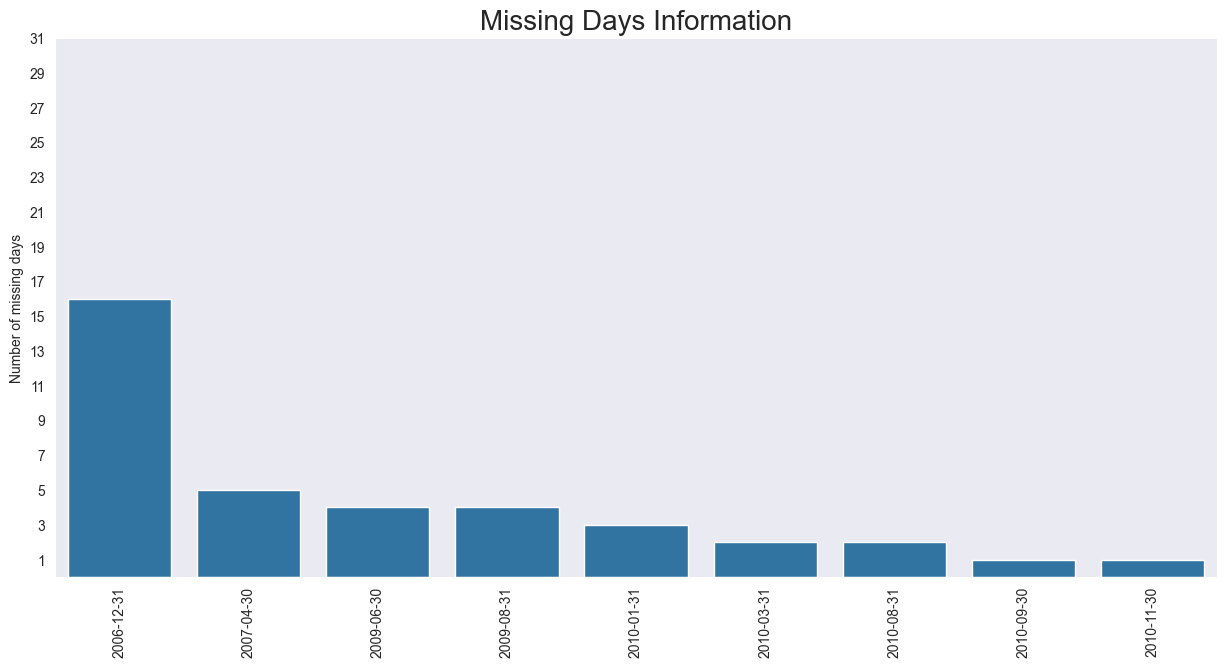

In [9]:
# Let's find out how many days have not been recoreded in our dataset
missing_days_df = np.round(full_df[['Global_active_power_wh']].resample('ME').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

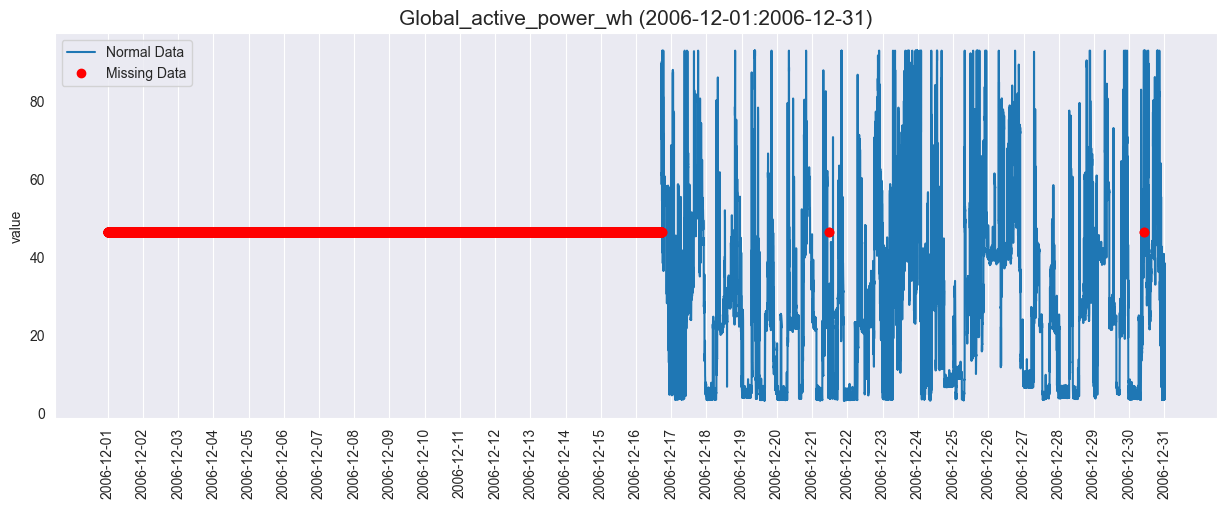

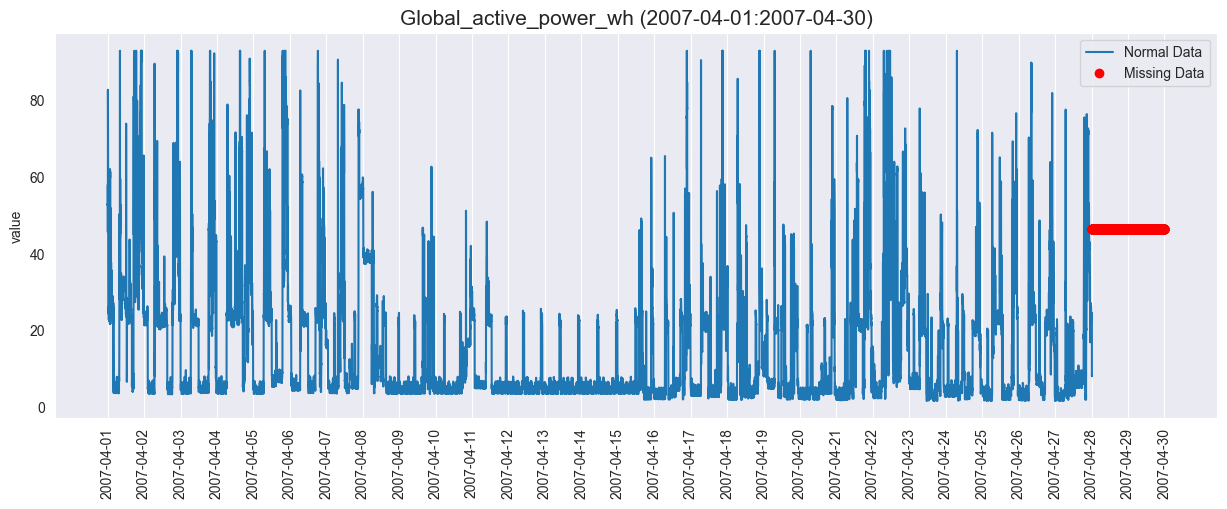

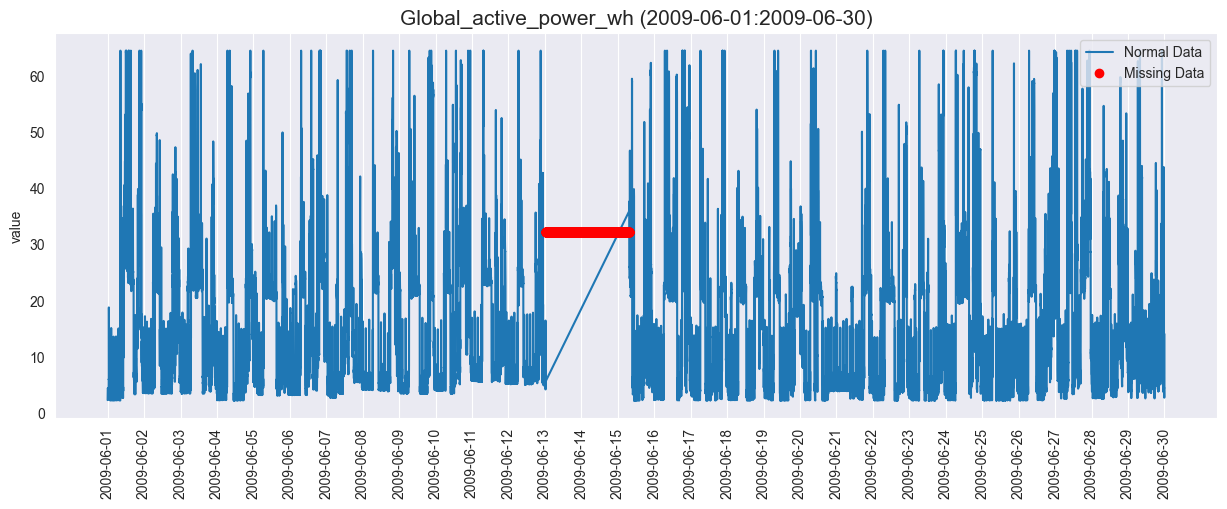

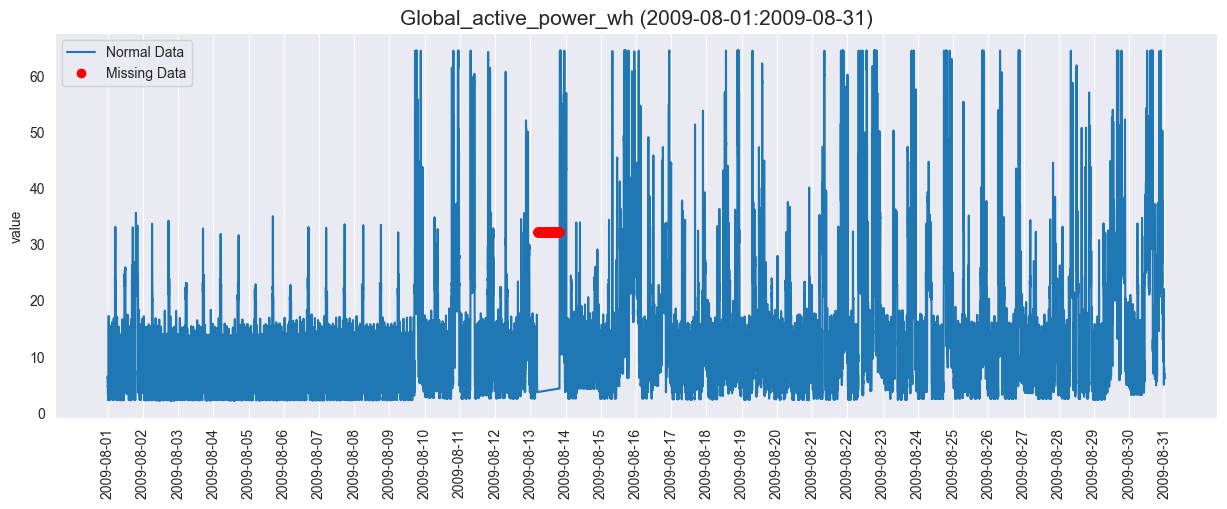

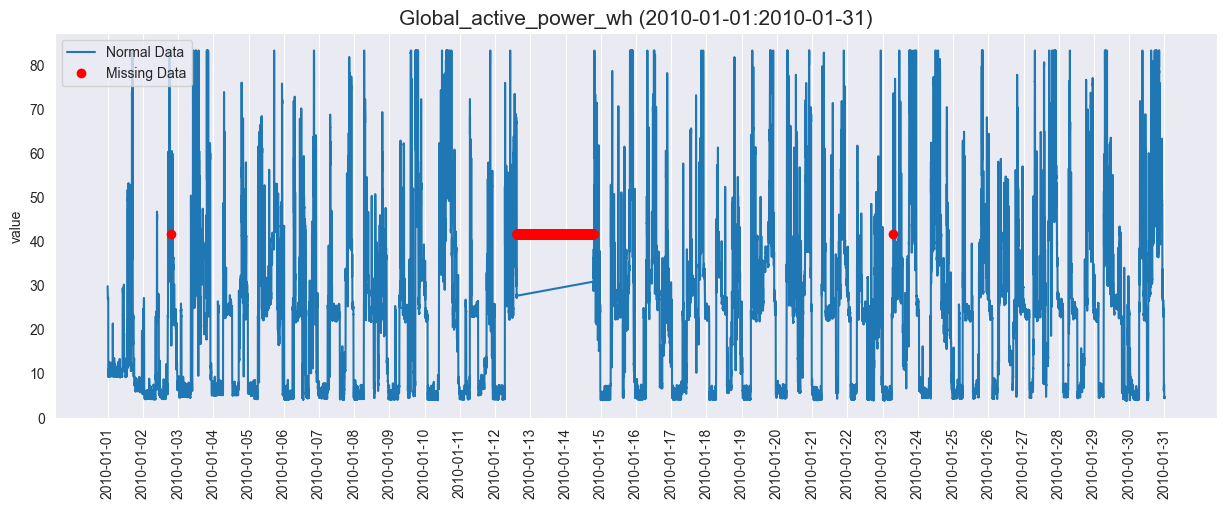

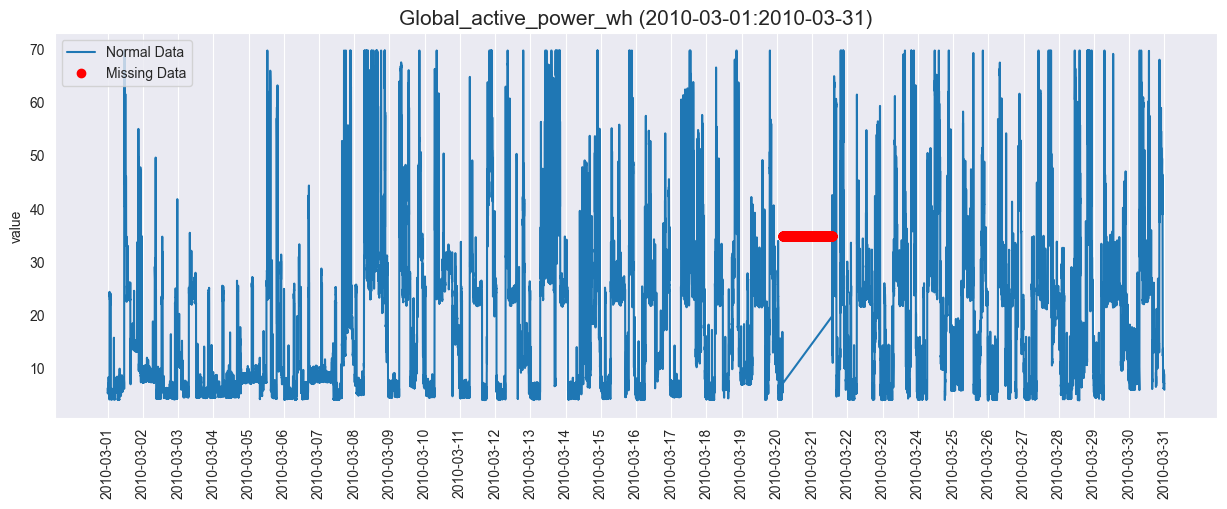

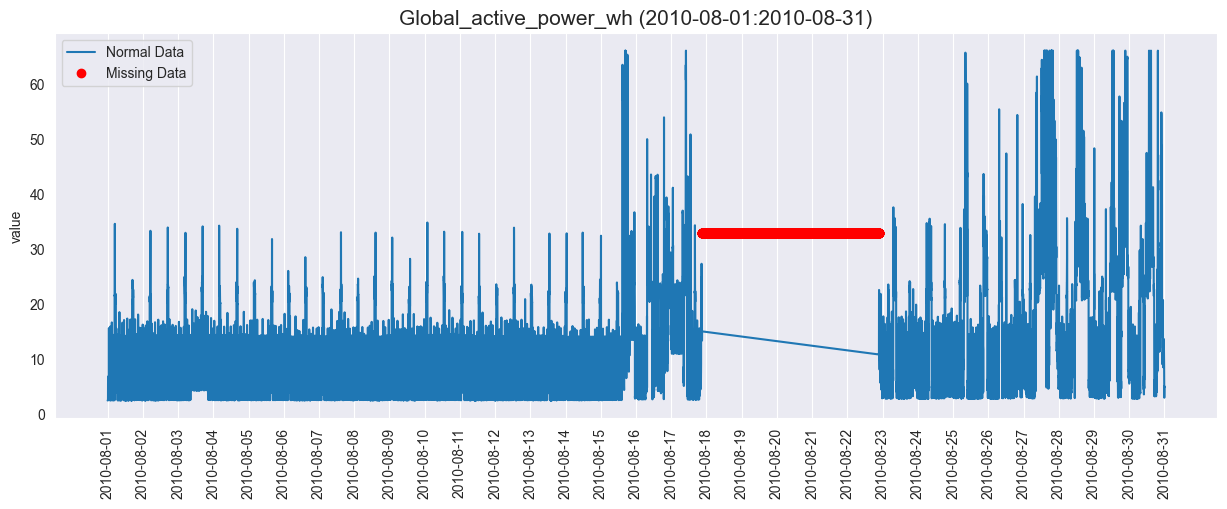

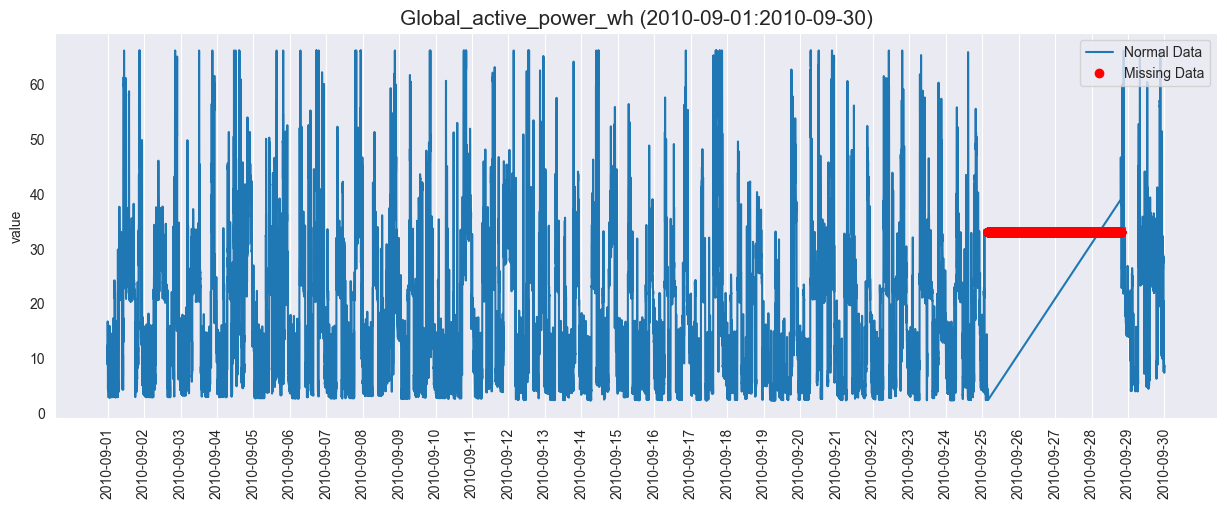

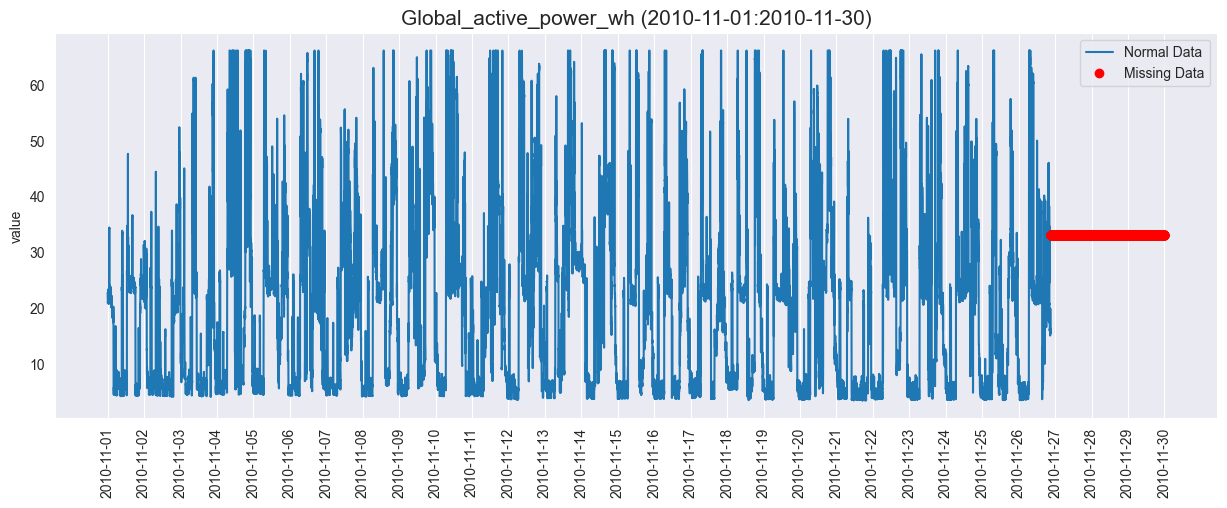

In [10]:
import datetime
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_energy" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1min')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = full_df[['Global_active_power_wh']][full_df.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_power_wh']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_power_wh']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_power_wh']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_power_wh ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None
for day in missing_days_df.index.date:
    plot_day_data(day)

**Conclusions** <br>
As was reported in the dataset information, we can see that the data contains missing data as gaps. <br>
The data collection for the first month didn't start from the beginning of the month, but on the 17th (Dec 2006).<br>
The data collection for the last month ended before the end of the month, on the 27th (Nov. 2010). <br>
There are 7 more gaps, as seen in the plots above.

## 2.1 Visualize Time Series Trends


In [11]:
def resample_data(full_df, res = '2min'):
    # Assuming 'full_df' has a datetime index 'dt'
    full_df["Datetime"] = full_df.index  # Ensure the datetime index is a column

    # Resample to 2-minute intervals by taking the mean
    resampled_df = full_df.resample(res, on="Datetime").mean()

    # Drop rows with NaN values after resampling
    resampled_df = resampled_df.dropna()

    # Print the first few rows to check the result
    print(resampled_df.head())

    return resampled_df

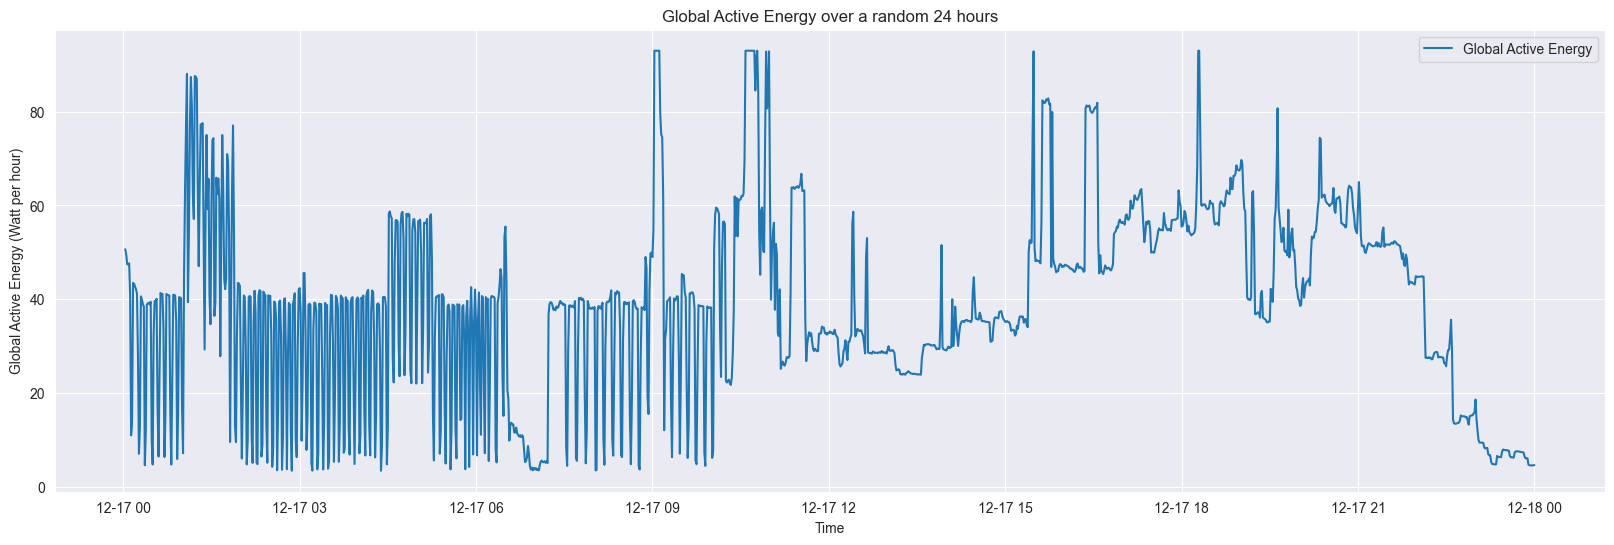

            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-16             3.034131               0.088187  236.243763   
2006-12-17             2.348336               0.156949  240.087028   
2006-12-18             1.530032               0.112356  241.231694   
2006-12-19             1.144865               0.104821  241.999313   
2006-12-20             1.543706               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-16         13.082828        0.000000        1.378788       12.439394   
2006-12-17          9.999028        1.411806        2.907639        9.264583   
2006-12-18          6.421667        0.738194        1.820139        9.734722   
2006-12-19          4.926389        0.582639        5.279167        4.303472   
2006-12-20          6.467361 

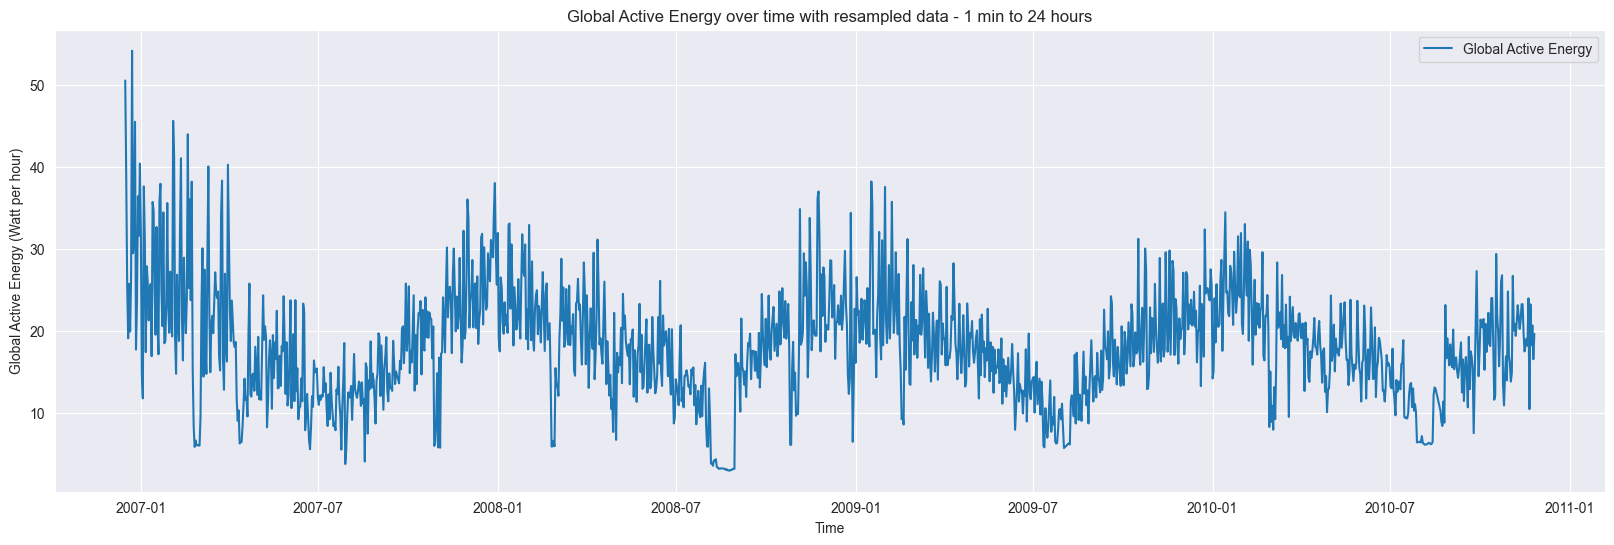

            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-31             1.886638               0.131386  241.441125   
2007-01-31             1.534599               0.132676  240.905101   
2007-02-28             1.392162               0.113637  240.519390   
2007-03-31             1.311469               0.114747  240.513469   
2007-04-30             0.888015               0.118778  239.400026   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-31          8.029956        1.248636        2.214987        7.409558   
2007-01-31          6.546915        1.264237        1.775931        7.383351   
2007-02-28          5.914569        1.180217        1.602361        6.703557   
2007-03-31          5.572979        1.361343        2.346872        6.504648   
2007-04-30          3.825676 

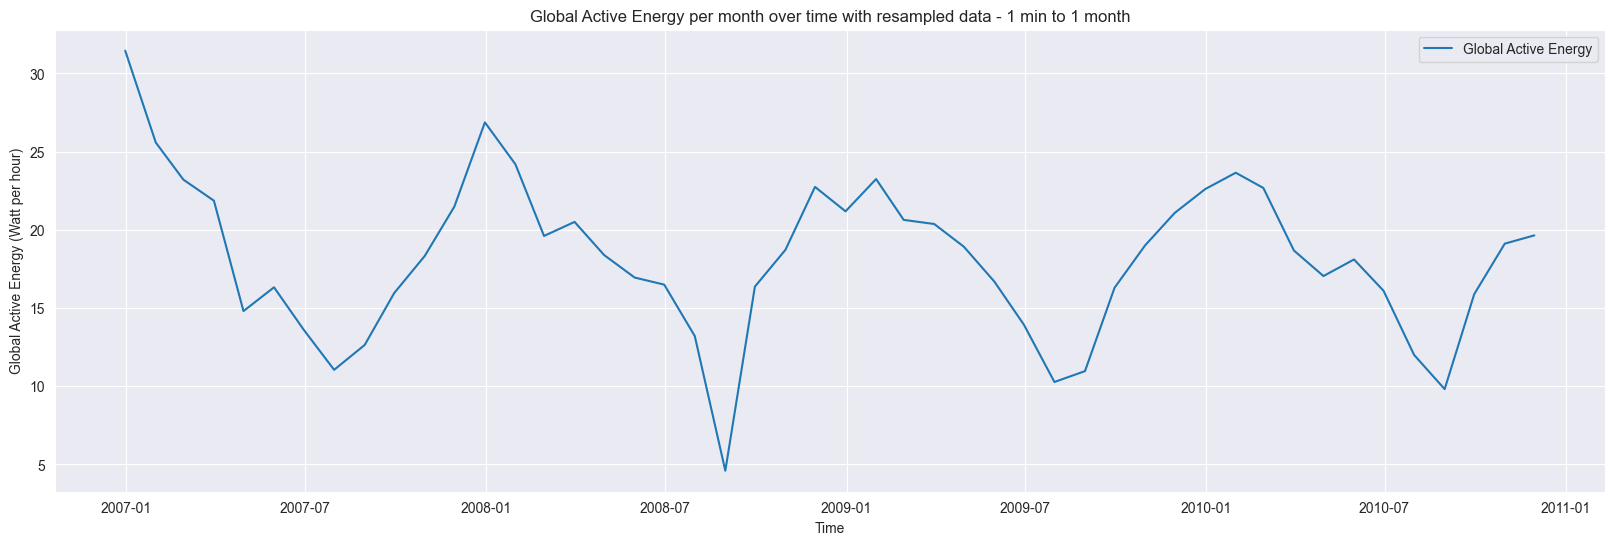

In [12]:
def visualize_time_series_trends(df: pd.DataFrame, title = "Global Active Energy over Time"):
    # Plot Global_active_power over time
    plt.figure(figsize=(20, 6))
    plt.plot(df["Global_active_power_wh"], label="Global Active Energy")
    plt.xlabel("Time")
    plt.ylabel("Global Active Energy (Watt per hour)")
    plt.title(title)
    plt.legend()
    plt.show()


#visualize_time_series_trends(full_df) # Visualizing only all the df without changes
visualize_time_series_trends(full_df.iloc[398:1837], "Global Active Energy over a random 24 hours" ) # Visualizing only 24 hours from original df

resampled_1min_to_24h_df = resample_data(full_df,'1440min') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_24h_df, "Global Active Energy over time with resampled data - 1 min to 24 hours" )
resampled_1min_to_24h_df = resample_data(full_df,'1ME') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_24h_df, "Global Active Energy per month over time with resampled data - 1 min to 1 month" )

**Conclusions:** <br>
As the original sample rate of the data is 1/min, it's not possible to plot the full ~4 years of data in one graph.<br>
We plotted 24 hours of the data with the original sample rate to give an example to the intraday variations.<br>
We resampled the data from 1 min to 24 hours and plotted the full duration. We can see that the plot is still very noisy, but we can see the trend and seasonality.<br>
We resampled the data from 1 min to 1 month and plotted the full duration to see the more robust trend and seasonality in the monthly billing.<br>
We will disuse the seasonality further later.

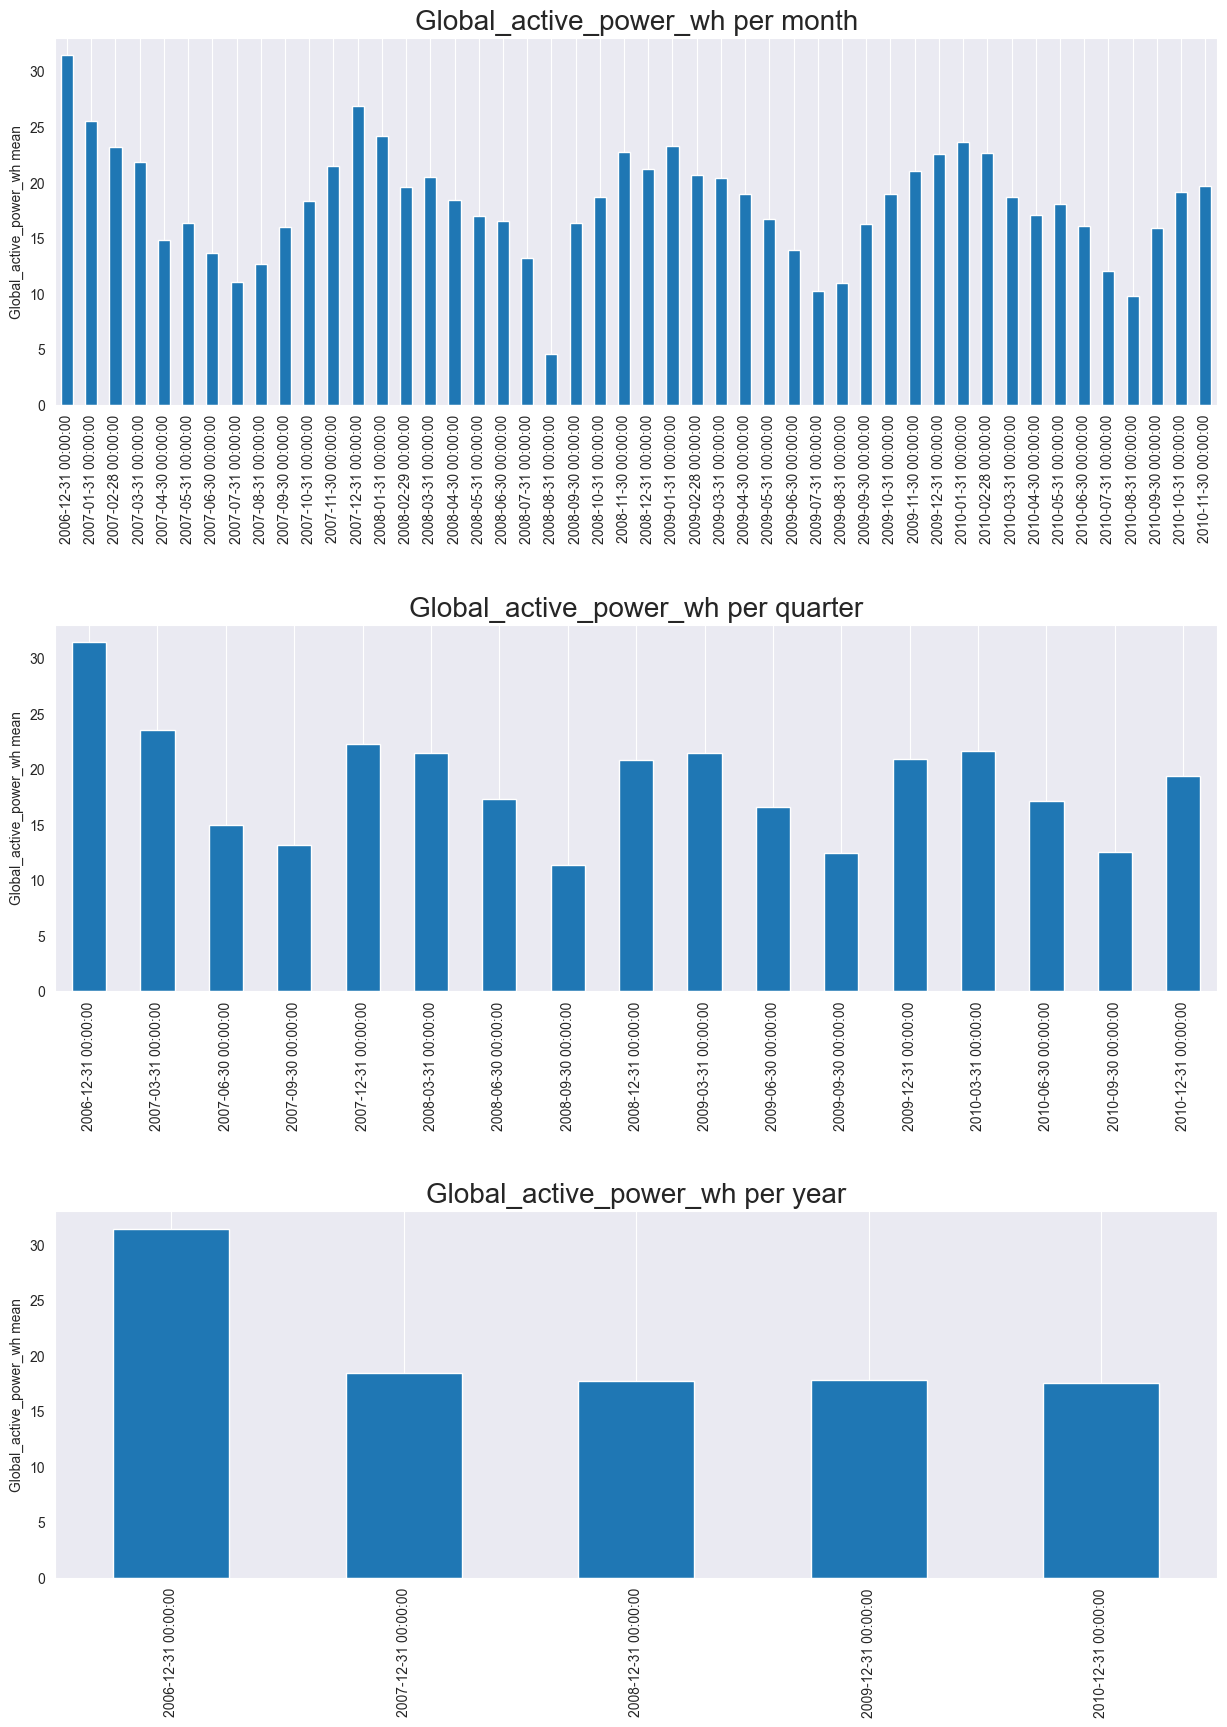

-----------------------------


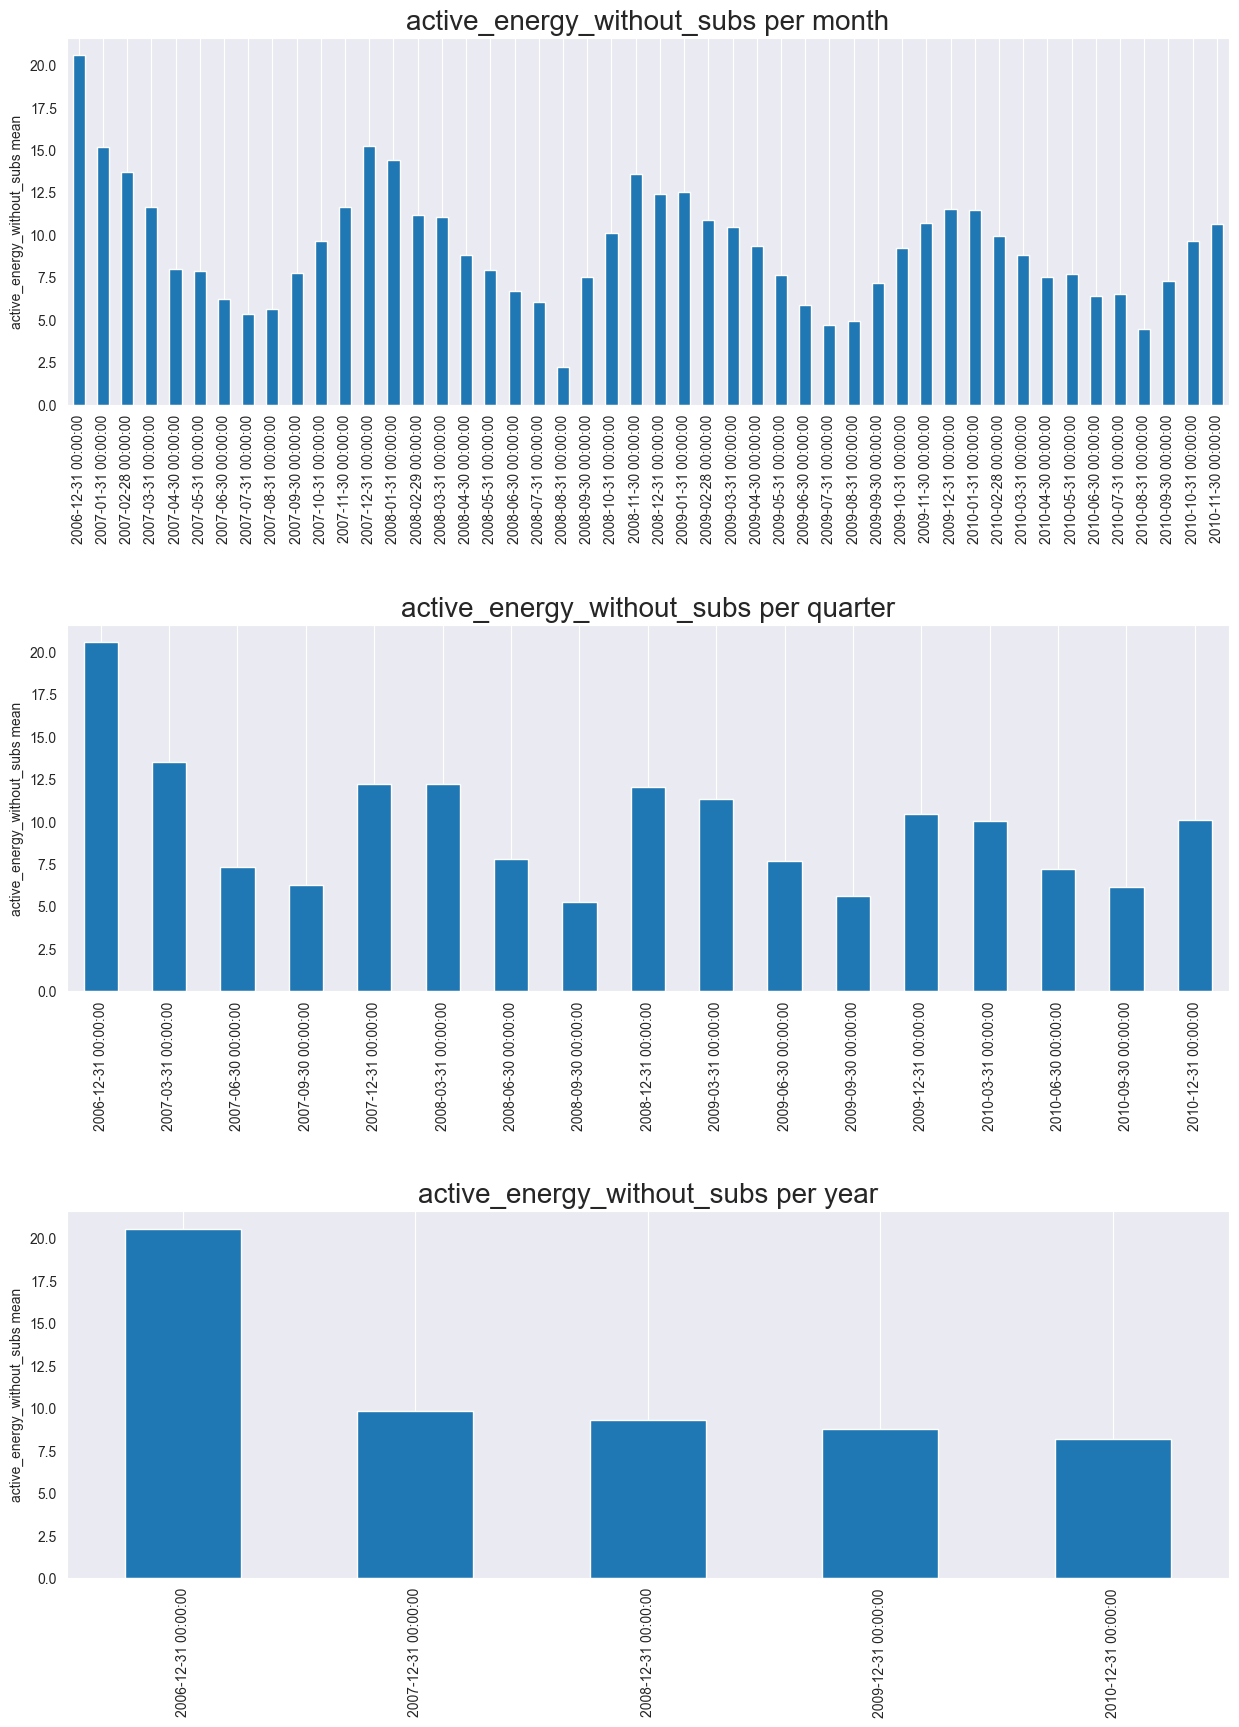

-----------------------------


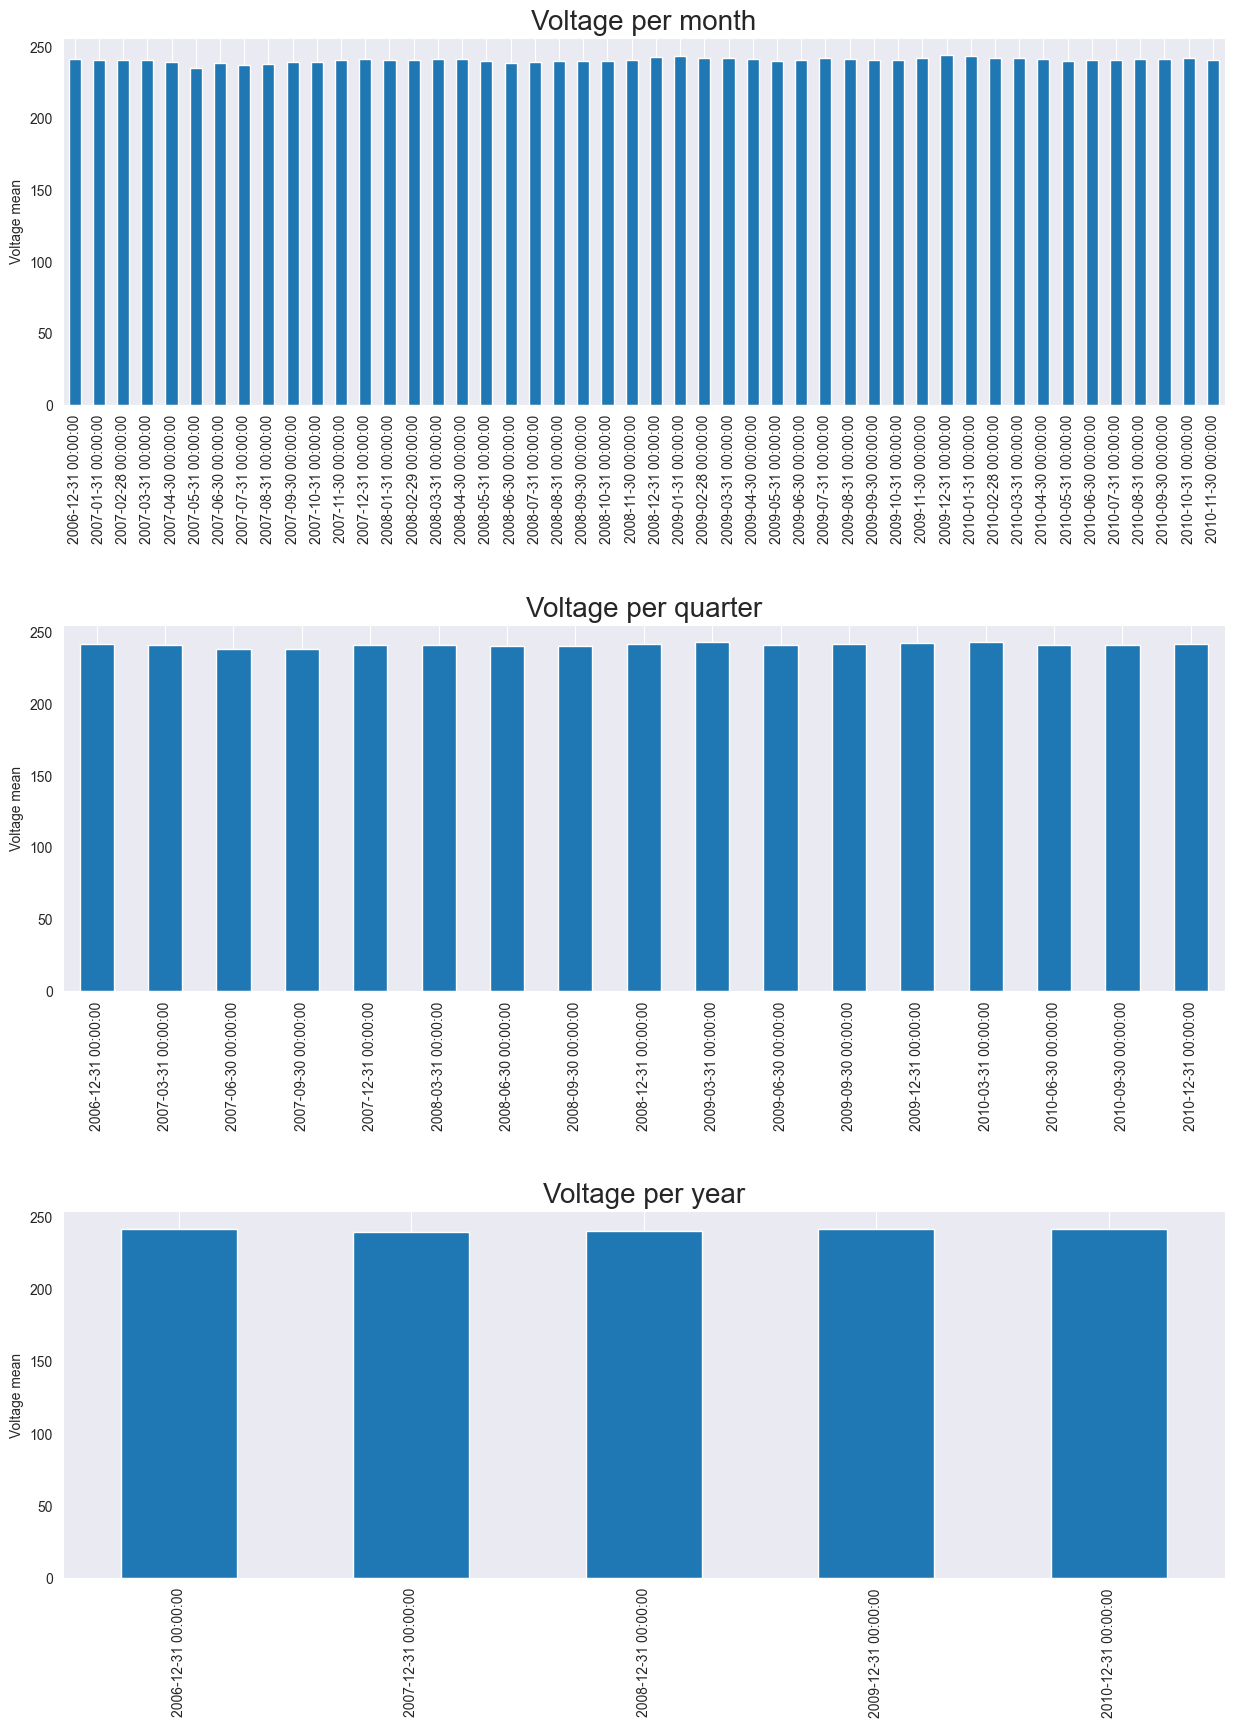

-----------------------------


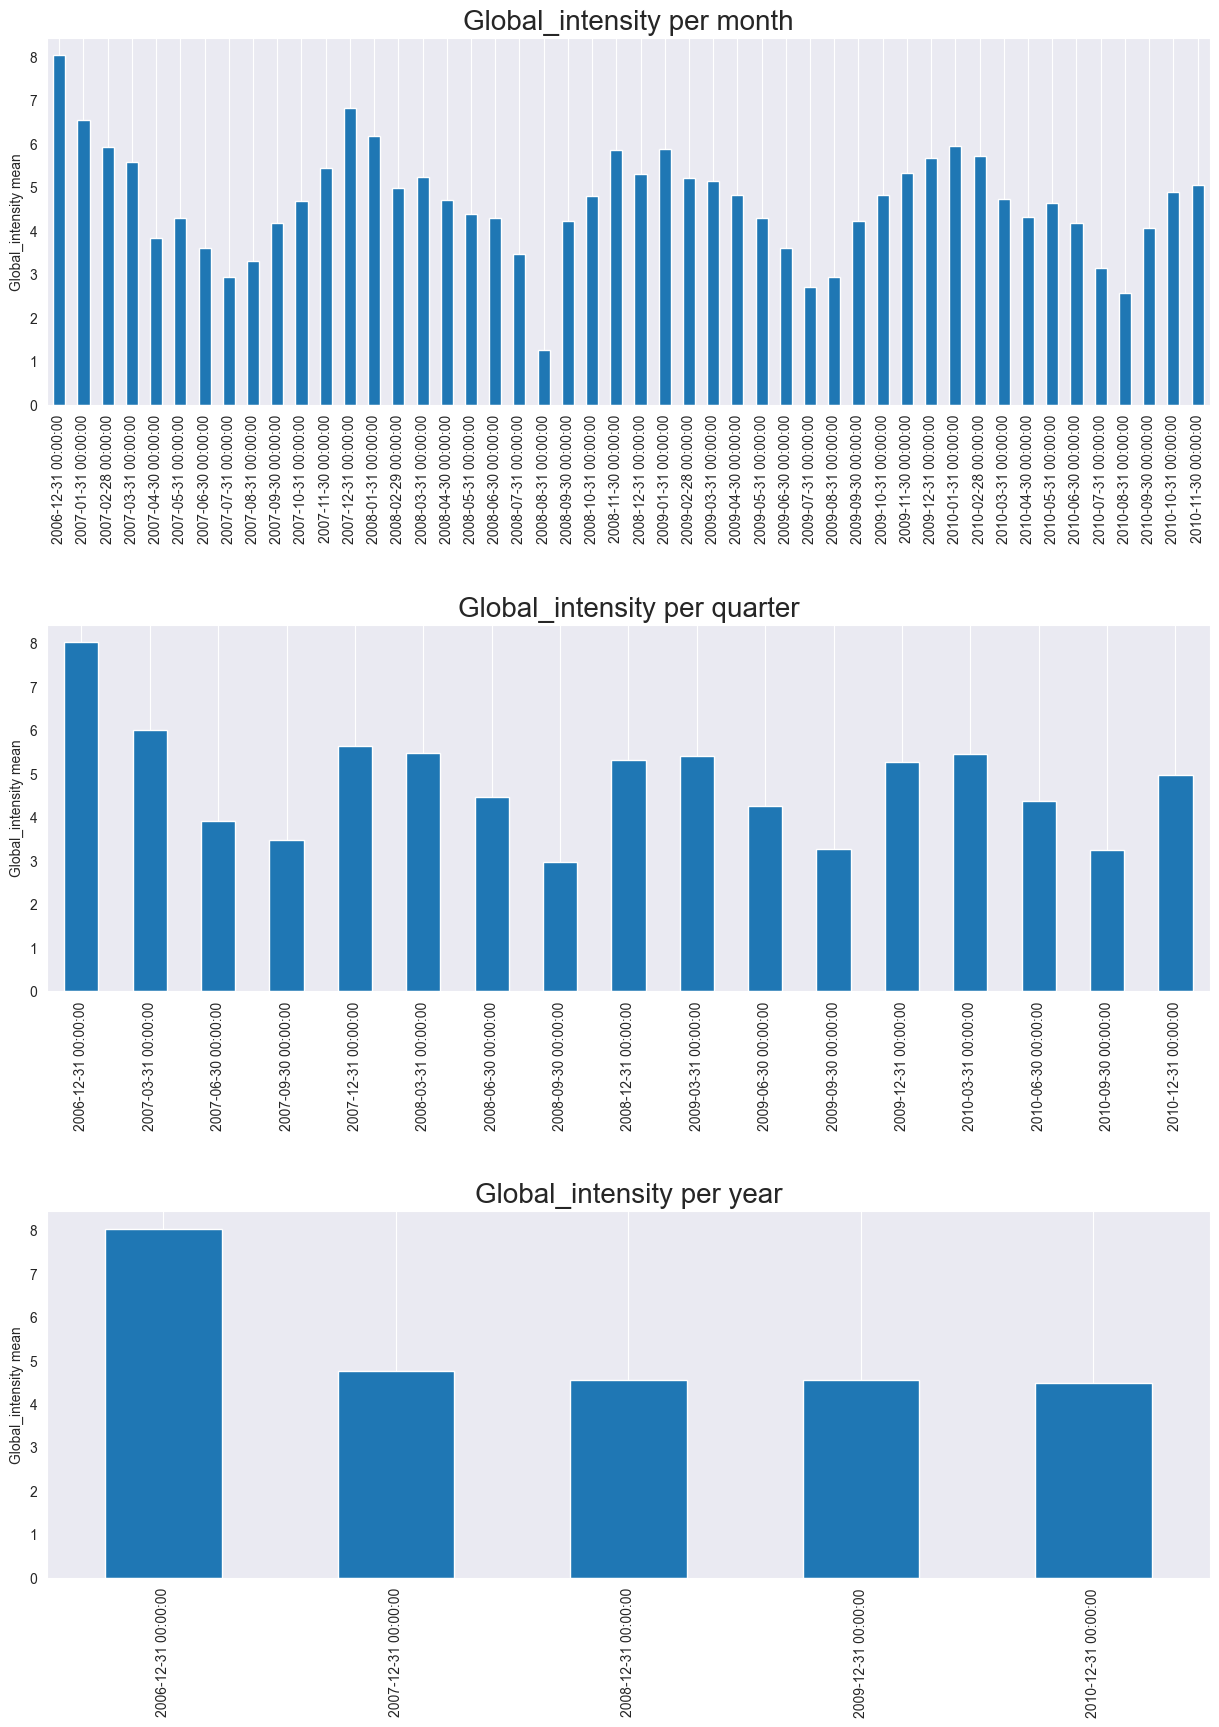

-----------------------------


In [13]:
def feature_analyser(feature:str,df:pd.DataFrame) -> None:
    '''
    This function is to plot mean value of 
    given feature resampled over 'M','Q' and 'Y'

    Parameters:
        feature : string : Column name in the dataframe to be analyzed.
        df : Pandas dataframe : Dataframe to be used for analysis.

    Returns:
        None
    '''
    # Create subplots with 3 rows and 1 column, and set figure size
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
    plt.subplots_adjust(hspace=0.6)  
    
    # Loop through resample intervals: monthly, quarterly, and yearly
    for number, resample in enumerate(['ME', 'QE', 'YE']):
        
        df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
        ax[number].set_ylabel('{} mean'.format(feature))
        
        # Set title for each subplot
        if resample == 'ME':
            ax[number].set_title('{} per month'.format(feature), fontsize=20)
        if resample == 'QE':
            ax[number].set_title('{} per quarter'.format(feature), fontsize=20)
        if resample == 'YE':
            ax[number].set_title('{} per year'.format(feature), fontsize=20)
            
        ax[number].set_xlabel('')
        ax[number].grid(axis='y')
        plt.xticks(rotation=90)
        
    plt.show()
    
    print('-----------------------------')
    
    return None

for i in full_df[['Global_active_power_wh','active_energy_without_subs','Voltage','Global_intensity']]:
    feature_analyser(i,full_df)

**Conclusions** <br>
We didn't plot the global reactive power and sub metering features, as we don't think they are relevant to the prediction or for this analysis.<br>

From the plots we can see that:<br>

As expected (from a scientific aspect), the Voltage is constant. We will not use it.<br>
As expected (from a scientific aspect), the intensity has the same pattern as the global power \ energy (power = voltage x Intensity). We will not use it.<br>
The global power Global active energy and the active energy without subs are very similar as the 2nd is a function of the 1st.<br> We created the active energy without subs feature so we wont need to use the 3 sub metering to train the models. We will run a correlation matrix to verify the correlations.

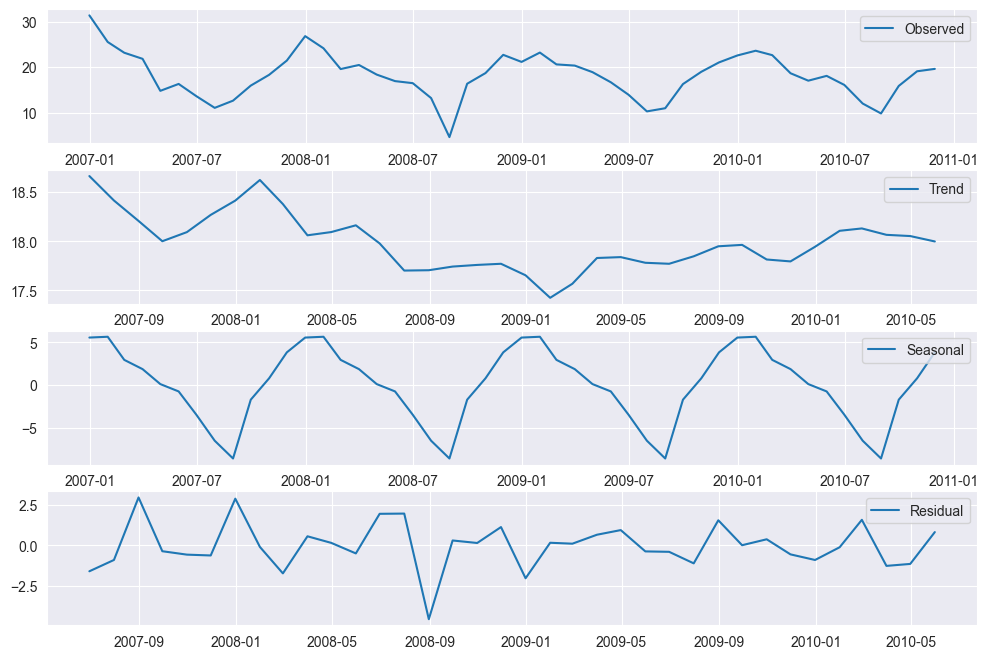

In [14]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_power_wh"].dropna(), model="additive", #period=24
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(resampled_1min_to_24h_df)

**Conclusions** <br>
We can see that there is seasonality in the data.<br>
An increase in energy consumption in colder months (autumn and winter) and a reduction in the spring and summer months.<br>
The overall trend is not distinct, it probably fallows the weather of that year, a colder winter means higher energy consumption.<br>

## 2.3 Analyze Distribution of Power Consumption

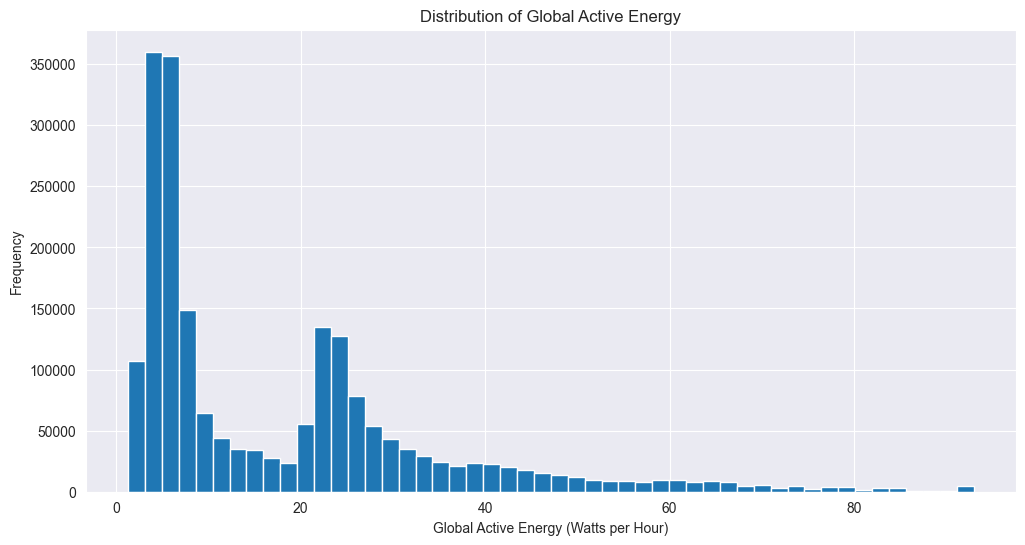

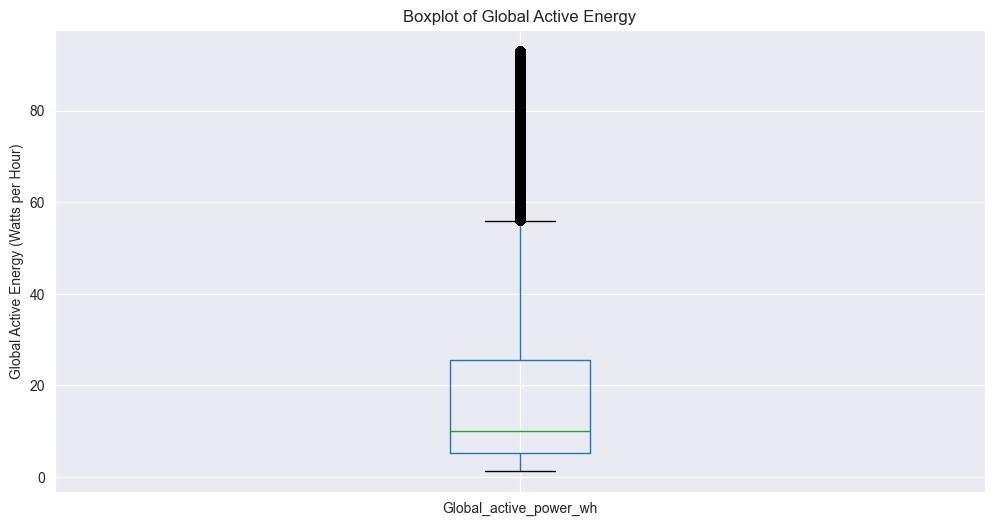

In [15]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power_wh"].hist(bins=50)
    plt.xlabel("Global Active Energy (Watts per Hour)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Energy")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power_wh")
    plt.ylabel("Global Active Energy (Watts per Hour)")
    plt.title("Boxplot of Global Active Energy")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

**Conclusions** <br>
From the energy distribution and from the boxplot, we can see that the majority of the energy consumption is low with a median less than 10. <br>
We see there are energy consumption peaks marked as outliers on the boxplot.

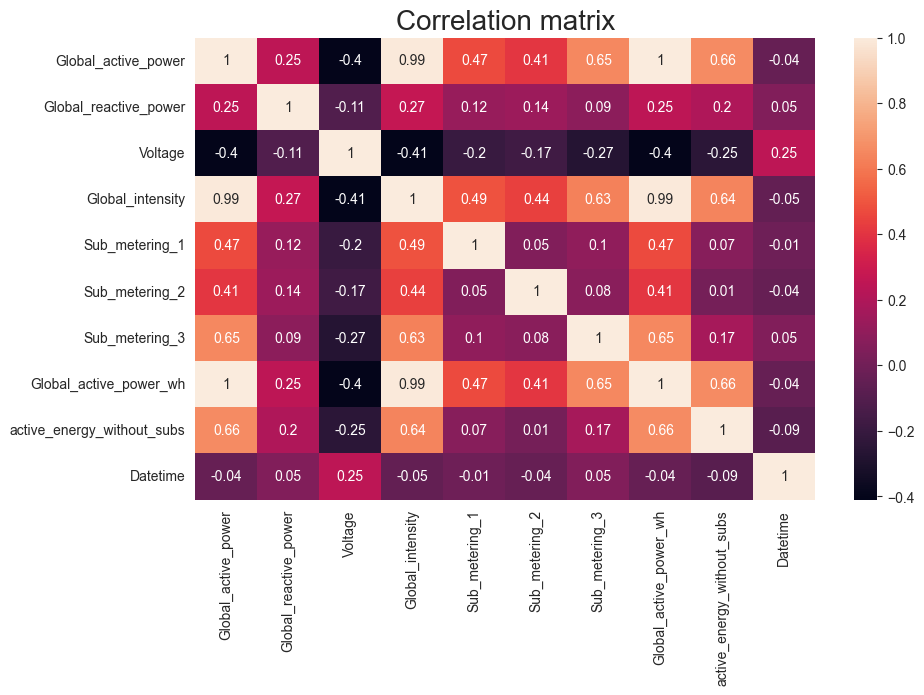

In [16]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(full_df.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

**Conclusions** <br>
As we wrote before, Global active energy/power is fully correlated to the global intensity. <br> We can see that the Global active energy/power is not fully correlated with the active energy without subs. So we think it has information that may help the prediction.

# 3. Implement a linear regression model to predict power consumption for the last three time periods

In [17]:
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from src.task_2.evaluation.model_evaluation import run_model_evaluation

In [18]:

# Define the target variable and features
full_df["Datetime"] = full_df["Datetime"].values.astype(np.int64) // 10 ** 9

X = full_df[["Datetime"]]
y = full_df["Global_active_power_wh"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1639424, 1)
Testing set size: (409856, 1)


In [19]:
# Initialize the models
linear_reg = LinearRegression()

# Train Linear Regression
linear_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_lr = linear_reg.predict(X_test)

# Evaluate the model
lr_results = run_model_evaluation(y_test, y_pred_lr)

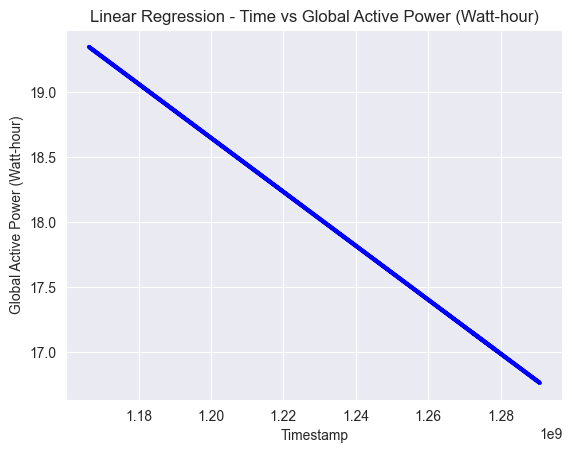

In [20]:
# Plot outputs
plt.xlabel("Timestamp")
plt.ylabel("Global Active Power (Watt-hour)")
plt.plot(X_test, y_pred_lr, color="blue", linewidth=3)
plt.title("Linear Regression - Time vs Global Active Power (Watt-hour)")

plt.show()

# 4. Evaluate the linear regression model using appropriate metrics

In [21]:
print(json.dumps(lr_results, indent=1))

{
 "Mean Absolute Error (MAE)": 13.458001699822255,
 "Mean Squared Error (MSE)": 288.0102782758172,
 "Root Mean Squared Error (RMSE)": 16.97086557238072,
 "R-squared (R\u00b2) value": 0.001789971866712592
}


**conclusions** <br>
We can see that the linear regression model has no meaning in a time series, it can only predict the overall trend. <br>
In this case the trend is an overall reduction in power consumption over time. <br>
We can see that the RMSE is very high and the R-squared is very low, thus the model prediction is very poor.

# 5. Implement a Recurrent Neural Network (RNN) for power consumption prediction

In [22]:
from keras import Sequential, layers, callbacks

In [23]:
full_df = full_df.drop(['Datetime'], axis=1)
full_df = full_df.dropna()

In [24]:
# Prepare the data with lagged features
full_df["lag_1"] = full_df["Global_active_power"].shift(1)
# Drop any rows with NaN values created by the shift operation
full_df = full_df.dropna()

In [25]:
# Resample to hourly intervals
df_hourly = full_df.resample('h').mean()
df_hourly = df_hourly.dropna()

In [26]:
# Define the target variable and features
features = ['Global_active_power_wh', 'active_energy_without_subs', 'lag_1']
target = ['Global_active_power_wh']

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features].iloc[i:i + sequence_length].values
        label = data[target].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 12
sequences, targets = create_sequences(df_hourly, sequence_length)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Scale the features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [28]:
# Design the RNN model
rnn_model = Sequential()
rnn_model.add(layers.SimpleRNN(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the RNN model
rnn_history = rnn_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/50


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 - 2s - 28ms/step - loss: 0.2271
Epoch 2/50
72/72 - 0s - 3ms/step - loss: 0.1184
Epoch 3/50
72/72 - 0s - 2ms/step - loss: 0.0821
Epoch 4/50
72/72 - 0s - 3ms/step - loss: 0.0679
Epoch 5/50
72/72 - 0s - 3ms/step - loss: 0.0539
Epoch 6/50
72/72 - 0s - 3ms/step - loss: 0.0388
Epoch 7/50
72/72 - 0s - 3ms/step - loss: 0.0364
Epoch 8/50
72/72 - 0s - 3ms/step - loss: 0.0277
Epoch 9/50
72/72 - 0s - 3ms/step - loss: 0.0249
Epoch 10/50
72/72 - 0s - 3ms/step - loss: 0.0235
Epoch 11/50
72/72 - 0s - 3ms/step - loss: 0.0208
Epoch 12/50
72/72 - 0s - 3ms/step - loss: 0.0200
Epoch 13/50
72/72 - 0s - 3ms/step - loss: 0.0187
Epoch 14/50
72/72 - 0s - 2ms/step - loss: 0.0185
Epoch 15/50
72/72 - 0s - 3ms/step - loss: 0.0168
Epoch 16/50
72/72 - 0s - 3ms/step - loss: 0.0166
Epoch 17/50
72/72 - 0s - 2ms/step - loss: 0.0164
Epoch 18/50
72/72 - 0s - 2ms/step - loss: 0.0160
Epoch 19/50
72/72 - 0s - 2ms/step - loss: 0.0155
Epoch 20/50
72/72 - 0s - 2ms/step - loss: 0.0158
Epoch 21/50
72/72 - 0s - 2ms/step - los

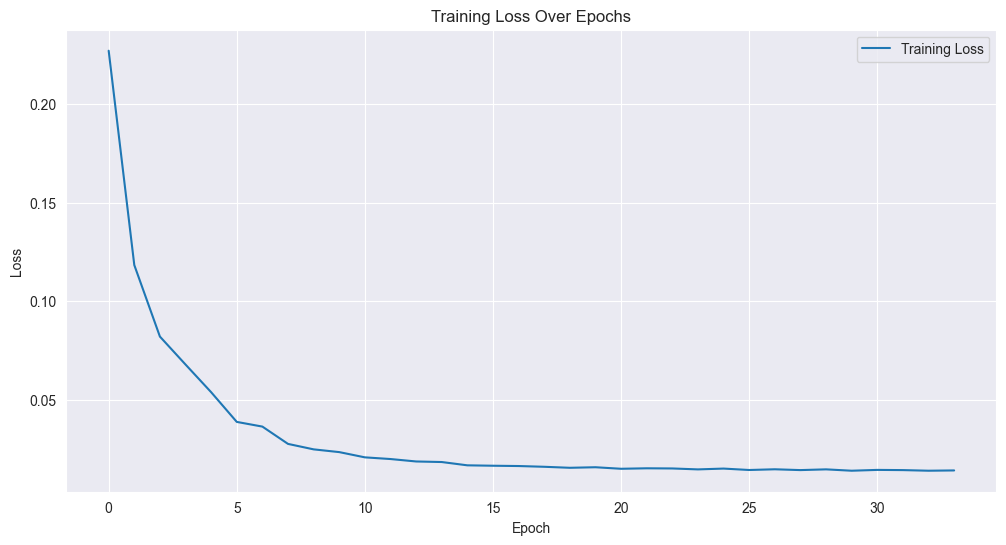

In [29]:
def plot_training_history(history):
    # Plot the training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()


plot_training_history(rnn_history)

In [30]:
# Make predictions with the RNN model
y_pred_train_rnn = rnn_model.predict(X_train_scaled)
y_pred_test_rnn = rnn_model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_pred_train_rnn_inv = scaler_y.inverse_transform(y_pred_train_rnn).reshape(-1)
y_pred_test_rnn_inv = scaler_y.inverse_transform(y_pred_test_rnn).reshape(-1)
y_train_inv = scaler_y.inverse_transform(y_train_scaled).reshape(-1)
y_test_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


RNN - MAE: 7.433041518508937, MSE: 114.11046034779466, RMSE: 10.682249779320584,R²: 0.5513960394911411


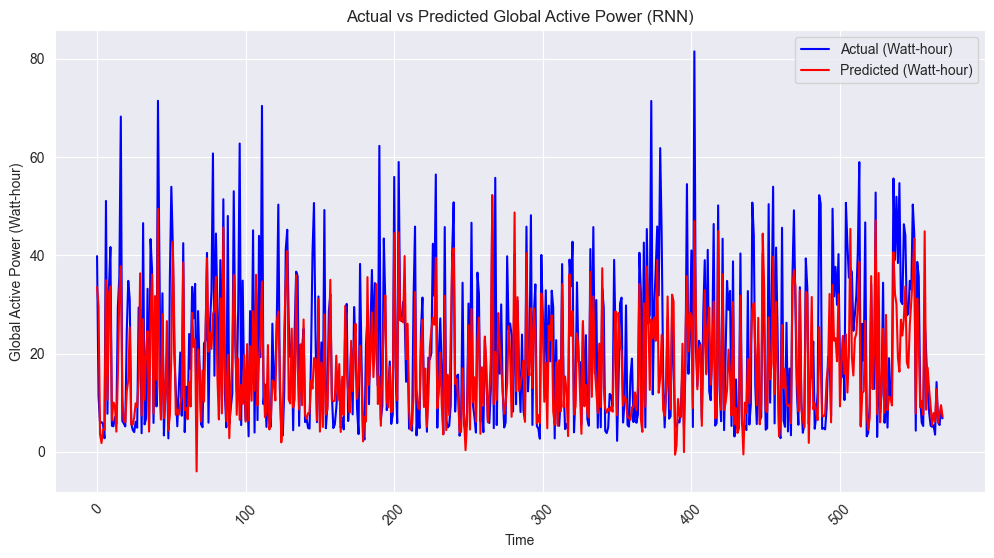

In [31]:
# Evaluate RNN model performance
import math
mae_rnn = mean_absolute_error(y_test_inv, y_pred_test_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, y_pred_test_rnn_inv)
rmse_rnn = math.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, y_pred_test_rnn_inv)

print(f"RNN - MAE: {mae_rnn}, MSE: {mse_rnn}, RMSE: {rmse_rnn},R²: {r2_rnn}")

# Plot RNN predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_rnn_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (RNN)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## RNN Conclusions:
The RNN model demonstrate a RMSE score of 10.7, this is much better than the 17.0 received from the LR.
The plot of the actual vs predicted Global active power shows a good visual correlation of the main trend. 

# 6. Implement Long Short-Term Memory (LSTM) for power consumption prediction

In [32]:
# Design the LSTM model
lstm_model = Sequential()
lstm_model.add(layers.LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, )

# Train the LSTM model
lstm_history = lstm_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
72/72 - 2s - 31ms/step - loss: 0.0481
Epoch 2/50
72/72 - 0s - 4ms/step - loss: 0.0225
Epoch 3/50
72/72 - 0s - 4ms/step - loss: 0.0189
Epoch 4/50
72/72 - 0s - 4ms/step - loss: 0.0179
Epoch 5/50
72/72 - 0s - 4ms/step - loss: 0.0169
Epoch 6/50
72/72 - 0s - 4ms/step - loss: 0.0161
Epoch 7/50
72/72 - 0s - 5ms/step - loss: 0.0159
Epoch 8/50
72/72 - 0s - 5ms/step - loss: 0.0151
Epoch 9/50
72/72 - 0s - 5ms/step - loss: 0.0152
Epoch 10/50
72/72 - 0s - 5ms/step - loss: 0.0149
Epoch 11/50
72/72 - 0s - 6ms/step - loss: 0.0149
Epoch 12/50
72/72 - 0s - 5ms/step - loss: 0.0146
Epoch 13/50
72/72 - 0s - 5ms/step - loss: 0.0139
Epoch 14/50
72/72 - 0s - 4ms/step - loss: 0.0145
Epoch 15/50
72/72 - 0s - 4ms/step - loss: 0.0141
Epoch 16/50
72/72 - 0s - 4ms/step - loss: 0.0142
Epoch 17/50
72/72 - 0s - 4ms/step - loss: 0.0142


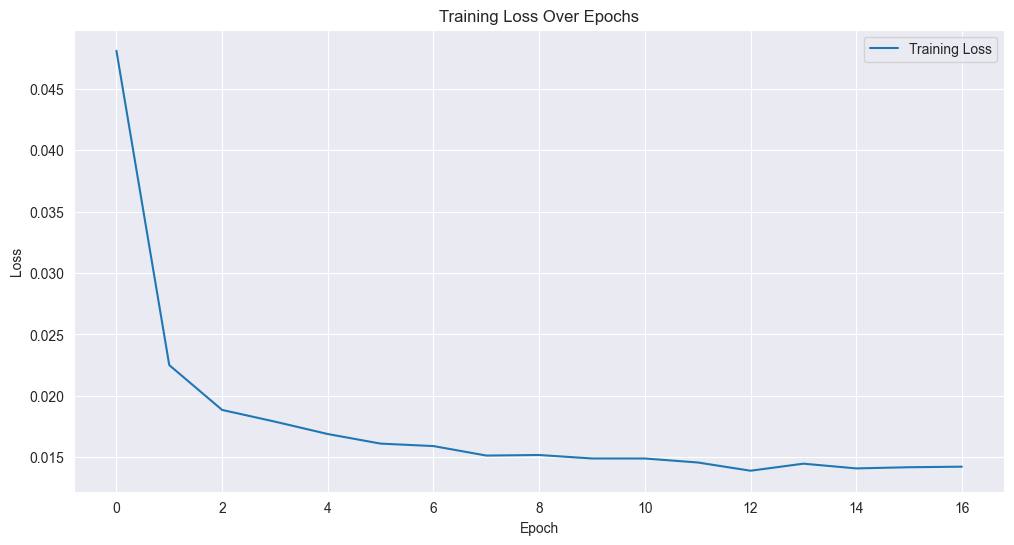

In [34]:
plot_training_history(lstm_history)

In [35]:
# Make predictions with the LSTM model
y_pred_train_lstm = lstm_model.predict(X_train_scaled)
y_pred_test_lstm = lstm_model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_pred_train_lstm_inv = scaler_y.inverse_transform(y_pred_train_lstm).reshape(-1)
y_pred_test_lstm_inv = scaler_y.inverse_transform(y_pred_test_lstm).reshape(-1)
y_train_lstm_inv = scaler_y.inverse_transform(y_train_scaled).reshape(-1)
y_test_lstm_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [36]:
# Evaluate LSTM model performance
mae_lstm = mean_absolute_error(y_test_lstm_inv, y_pred_test_lstm_inv)
mse_lstm = mean_squared_error(y_test_lstm_inv, y_pred_test_lstm_inv)
rmse_lstm = math.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_lstm_inv, y_pred_test_lstm_inv)

print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, R²: {r2_lstm}")

LSTM - MAE: 7.405726450646408, MSE: 111.51270140757674, RMSE: 10.55995745292455, R²: 0.5616086435370556


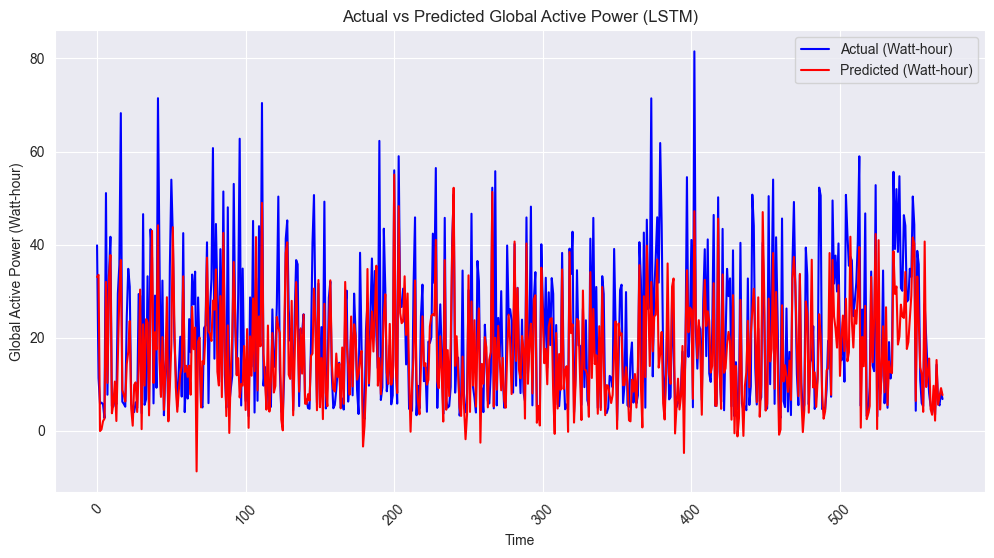

In [37]:
# Plot LSTM predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## LSTM Conclusions:
The LSTM model demonstrate a RMSE score of 10.6 , while the RNN model demonstrated an MSE score of 10.7.  
There is no significant differance between the modeles.


# 7. Implement an LSTM model with an Attention layer for power consumption prediction

In [38]:
from keras import Input, Model
import tensorflow as tf
 # Define the LSTM model with attention using the functional API
inputs = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
lstm_out = layers.LSTM(50, return_sequences=True, activation='relu')(inputs)
attention_out = layers.Attention()([lstm_out, lstm_out])
attention = layers.Flatten()(attention_out)  # Flatten the attention output to 2D
dense_out = layers.Dense(1)(attention)

In [39]:
lstm_attention_model = Model(inputs=inputs, outputs=dense_out)
lstm_attention_model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the LSTM model with attention
lstm_attention_history = lstm_attention_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])


Epoch 1/50
72/72 - 2s - 28ms/step - loss: 0.0338
Epoch 2/50
72/72 - 0s - 5ms/step - loss: 0.0304
Epoch 3/50
72/72 - 0s - 4ms/step - loss: 0.0297
Epoch 4/50
72/72 - 0s - 4ms/step - loss: 0.0287
Epoch 5/50
72/72 - 0s - 4ms/step - loss: 0.0277
Epoch 6/50
72/72 - 0s - 4ms/step - loss: 0.0268
Epoch 7/50
72/72 - 0s - 4ms/step - loss: 0.0258
Epoch 8/50
72/72 - 0s - 5ms/step - loss: 0.0246
Epoch 9/50
72/72 - 0s - 6ms/step - loss: 0.0234
Epoch 10/50
72/72 - 0s - 5ms/step - loss: 0.0222
Epoch 11/50
72/72 - 1s - 7ms/step - loss: 0.0210
Epoch 12/50
72/72 - 0s - 6ms/step - loss: 0.0201
Epoch 13/50
72/72 - 0s - 6ms/step - loss: 0.0193
Epoch 14/50
72/72 - 0s - 4ms/step - loss: 0.0179
Epoch 15/50
72/72 - 0s - 5ms/step - loss: 0.0161
Epoch 16/50
72/72 - 0s - 5ms/step - loss: 0.0151
Epoch 17/50
72/72 - 0s - 5ms/step - loss: 0.0146
Epoch 18/50
72/72 - 0s - 5ms/step - loss: 0.0144
Epoch 19/50
72/72 - 0s - 6ms/step - loss: 0.0142
Epoch 20/50
72/72 - 0s - 6ms/step - loss: 0.0140
Epoch 21/50
72/72 - 0s - 5ms

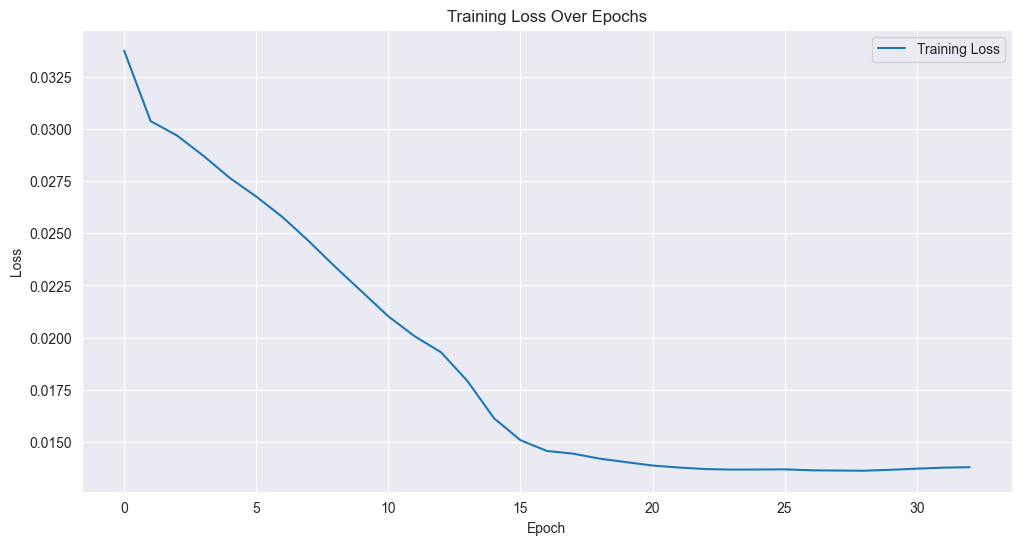

In [40]:
plot_training_history(lstm_attention_history)

In [41]:
# Make predictions with the LSTM model with attention
y_pred_train_lstm_attention = lstm_attention_model.predict(X_train_scaled)
y_pred_test_lstm_attention = lstm_attention_model.predict(X_test_scaled)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [42]:
# Inverse transform the predictions and actual values
y_pred_train_lstm_attention_inv = scaler_y.inverse_transform(y_pred_train_lstm_attention)
y_pred_test_lstm_attention_inv = scaler_y.inverse_transform(y_pred_test_lstm_attention)
y_train_lstm_attention_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_lstm_attention_inv = scaler_y.inverse_transform(y_test_scaled)

In [43]:
# Evaluate LSTM with attention model performance
mae_lstm_attention = mean_absolute_error(y_test_lstm_attention_inv, y_pred_test_lstm_attention_inv)
mse_lstm_attention = mean_squared_error(y_test_lstm_attention_inv, y_pred_test_lstm_attention_inv)
rmse_lstm_attention = math.sqrt(mse_lstm_attention)
r2_lstm_attention = r2_score(y_test_lstm_attention_inv, y_pred_test_lstm_attention_inv)

print(f"LSTM with Attention - MAE: {mae_lstm_attention}, MSE: {mse_lstm_attention}, RMSE: {rmse_lstm_attention}, R²: {r2_lstm_attention}")


LSTM with Attention - MAE: 8.880496603145458, MSE: 116.79153472450813, RMSE: 10.80701321941026, R²: 0.5408558963688833


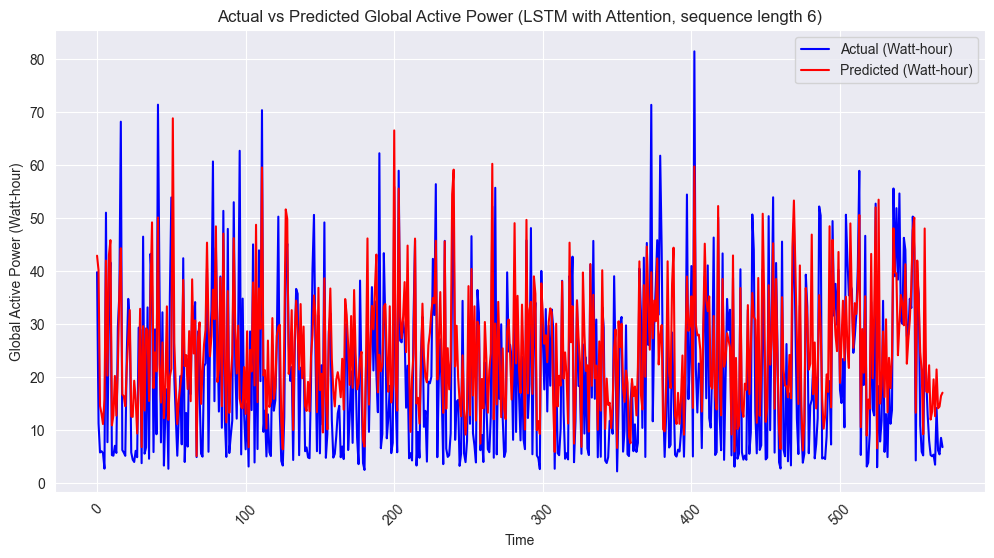

In [44]:
# Plot LSTM with attention predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_attention_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (LSTM with Attention, sequence length 6)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## LSTM with Attention Conclusions:
The LSTM with Attention model demonstrate a RMSE score of 10.8. This is surprisingly a bit higher than the LSTM and the RNN models (but basically the same result).    
We expected the addition of an attention mechanism to give better results. 

# 8. Data augmentation experiment

## 8.1 RUN RNN Model with 10 percent less data (resample with 66 minutes)

Epoch 1/50


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 - 2s - 31ms/step - loss: 0.3104
Epoch 2/50
65/65 - 0s - 2ms/step - loss: 0.2041
Epoch 3/50
65/65 - 0s - 2ms/step - loss: 0.1452
Epoch 4/50
65/65 - 0s - 3ms/step - loss: 0.0987
Epoch 5/50
65/65 - 0s - 3ms/step - loss: 0.0857
Epoch 6/50
65/65 - 0s - 3ms/step - loss: 0.0687
Epoch 7/50
65/65 - 0s - 3ms/step - loss: 0.0497
Epoch 8/50
65/65 - 0s - 3ms/step - loss: 0.0402
Epoch 9/50
65/65 - 0s - 3ms/step - loss: 0.0335
Epoch 10/50
65/65 - 0s - 2ms/step - loss: 0.0287
Epoch 11/50
65/65 - 0s - 2ms/step - loss: 0.0238
Epoch 12/50
65/65 - 0s - 3ms/step - loss: 0.0212
Epoch 13/50
65/65 - 0s - 3ms/step - loss: 0.0194
Epoch 14/50
65/65 - 0s - 3ms/step - loss: 0.0181
Epoch 15/50
65/65 - 0s - 3ms/step - loss: 0.0172
Epoch 16/50
65/65 - 0s - 3ms/step - loss: 0.0167
Epoch 17/50
65/65 - 0s - 3ms/step - loss: 0.0158
Epoch 18/50
65/65 - 0s - 2ms/step - loss: 0.0150
Epoch 19/50
65/65 - 0s - 3ms/step - loss: 0.0152
Epoch 20/50
65/65 - 0s - 3ms/step - loss: 0.0146
Epoch 21/50
65/65 - 0s - 3ms/step - los

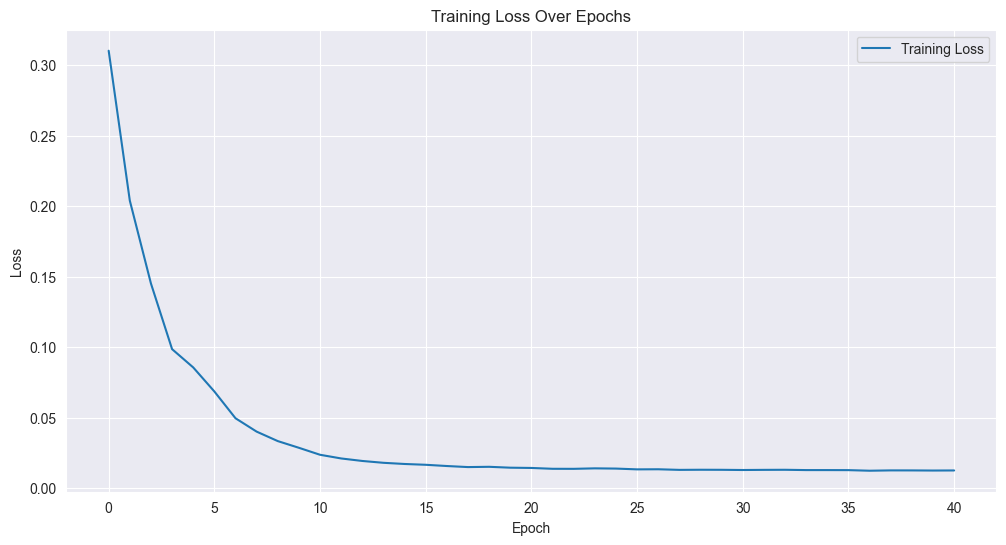

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
66min RNN - MAE: 8.235981766616655, MSE: 101.2850143737369, RMSE: 10.06404562657269, R²: 0.47912693663711237


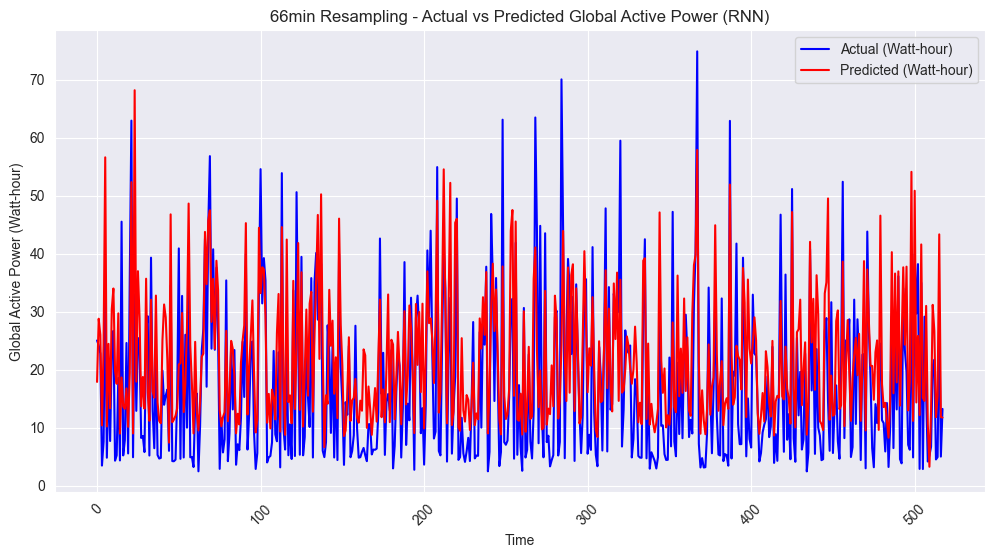

In [45]:
# Resample to 66-minute intervals
resampled_df_66min = full_df.resample('66min').mean()
resampled_df_66min = resampled_df_66min.dropna()

features_66min = ['Global_active_power_wh', 'active_energy_without_subs', 'lag_1']
target_66min = ['Global_active_power_wh']

def create_sequences_66min(data, sequence_length):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features_66min].iloc[i:i + sequence_length].values
        label = data[target_66min].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length_66min = 12
sequences_66min, targets_66min = create_sequences_66min(resampled_df_66min, sequence_length_66min)

# Train-test split
X_train_66min, X_test_66min, y_train_66min, y_test_66min = train_test_split(sequences_66min, targets_66min, test_size=0.2, random_state=42)

# Scale the features and target separately
scaler_X_66min = MinMaxScaler()
scaler_y_66min = MinMaxScaler()

X_train_scaled_66min = scaler_X_66min.fit_transform(X_train_66min.reshape(-1, X_train_66min.shape[-1])).reshape(X_train_66min.shape)
X_test_scaled_66min = scaler_X_66min.transform(X_test_66min.reshape(-1, X_test_66min.shape[-1])).reshape(X_test_66min.shape)

y_train_scaled_66min = scaler_y_66min.fit_transform(y_train_66min.reshape(-1, 1))
y_test_scaled_66min = scaler_y_66min.transform(y_test_66min.reshape(-1, 1))

# Design the RNN model
rnn_model_66min = Sequential()
rnn_model_66min.add(layers.SimpleRNN(50, activation='relu', input_shape=(X_train_scaled_66min.shape[1], X_train_scaled_66min.shape[2])))
rnn_model_66min.add(layers.BatchNormalization())
rnn_model_66min.add(layers.Dropout(0.2))
rnn_model_66min.add(layers.Dense(1))
rnn_model_66min.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping_66min = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the RNN model
rnn_history_66min = rnn_model_66min.fit(X_train_scaled_66min, y_train_scaled_66min, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_66min])

plot_training_history(rnn_history_66min)

# Make predictions with the RNN model
y_pred_train_rnn_66min = rnn_model_66min.predict(X_train_scaled_66min)
y_pred_test_rnn_66min = rnn_model_66min.predict(X_test_scaled_66min)

# Inverse transform the predictions and actual values
y_pred_train_rnn_66min_inv = scaler_y_66min.inverse_transform(y_pred_train_rnn_66min).reshape(-1)
y_pred_test_rnn_66min_inv = scaler_y_66min.inverse_transform(y_pred_test_rnn_66min).reshape(-1)
y_train_66min_inv = scaler_y_66min.inverse_transform(y_train_scaled_66min).reshape(-1)
y_test_66min_inv = scaler_y_66min.inverse_transform(y_test_scaled_66min).reshape(-1)

# Evaluate RNN model performance
mae_rnn_66min = mean_absolute_error(y_test_66min_inv, y_pred_test_rnn_66min_inv)
mse_rnn_66min = mean_squared_error(y_test_66min_inv, y_pred_test_rnn_66min_inv)
rmse_rnn_66min = math.sqrt(mse_rnn_66min)
r2_rnn_66min = r2_score(y_test_66min_inv, y_pred_test_rnn_66min_inv)

print(f"66min RNN - MAE: {mae_rnn_66min}, MSE: {mse_rnn_66min}, RMSE: {rmse_rnn_66min}, R²: {r2_rnn_66min}")

# Plot RNN predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_66min_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_rnn_66min_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('66min Resampling - Actual vs Predicted Global Active Power (RNN)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### RNN with 10% data down-sampling Conclusions:
The RNN model with 10% data down sampling demonstrate a RMSE score of 10.1, while the RMSE score before the down-sampling was 10.7.   
The 10% data down sampling acts as a smother of the data and improved the model accuracy.

## 8.2 RUN LSTM Model with 10 percent less data (resample with 66 minutes)

Epoch 1/50


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 - 2s - 31ms/step - loss: 0.0474
Epoch 2/50
65/65 - 0s - 4ms/step - loss: 0.0236
Epoch 3/50
65/65 - 0s - 4ms/step - loss: 0.0194
Epoch 4/50
65/65 - 0s - 4ms/step - loss: 0.0176
Epoch 5/50
65/65 - 0s - 4ms/step - loss: 0.0160
Epoch 6/50
65/65 - 0s - 4ms/step - loss: 0.0148
Epoch 7/50
65/65 - 0s - 4ms/step - loss: 0.0145
Epoch 8/50
65/65 - 0s - 4ms/step - loss: 0.0136
Epoch 9/50
65/65 - 0s - 4ms/step - loss: 0.0139
Epoch 10/50
65/65 - 0s - 4ms/step - loss: 0.0137
Epoch 11/50
65/65 - 0s - 4ms/step - loss: 0.0135
Epoch 12/50
65/65 - 0s - 4ms/step - loss: 0.0133
Epoch 13/50
65/65 - 0s - 4ms/step - loss: 0.0135
Epoch 14/50
65/65 - 0s - 4ms/step - loss: 0.0131
Epoch 15/50
65/65 - 0s - 4ms/step - loss: 0.0133
Epoch 16/50
65/65 - 0s - 4ms/step - loss: 0.0135
Epoch 17/50
65/65 - 0s - 4ms/step - loss: 0.0131
Epoch 18/50
65/65 - 0s - 4ms/step - loss: 0.0130
Epoch 19/50
65/65 - 0s - 4ms/step - loss: 0.0131
Epoch 20/50
65/65 - 0s - 4ms/step - loss: 0.0127
Epoch 21/50
65/65 - 0s - 4ms/step - los

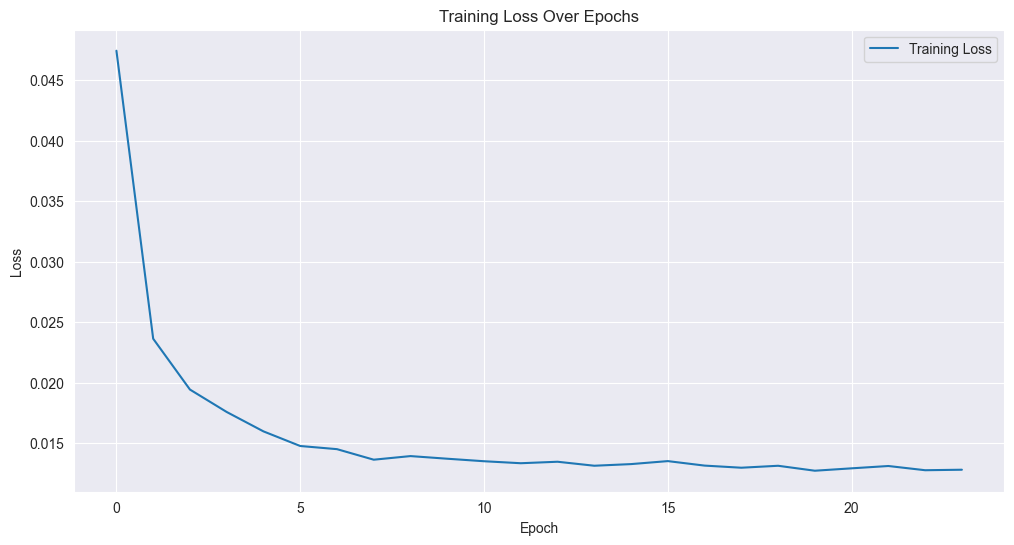

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
66min LSTM - MAE: 7.214230115922521, MSE: 87.38490972235257, RMSE: 9.347989608592458, R²: 0.5506102664820914


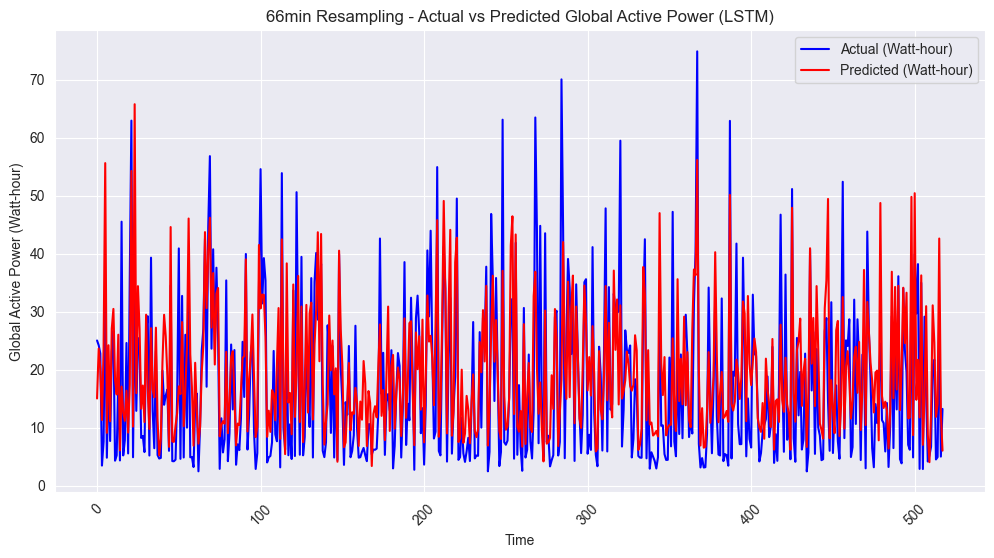

In [46]:
# Design the LSTM model
lstm_model_66min = Sequential()
lstm_model_66min.add(layers.LSTM(50, activation='relu', input_shape=(X_train_scaled_66min.shape[1], X_train_scaled_66min.shape[2])))
lstm_model_66min.add(layers.BatchNormalization())
lstm_model_66min.add(layers.Dropout(0.2))
lstm_model_66min.add(layers.Dense(1))
lstm_model_66min.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping_66min = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the LSTM model
lstm_history_66min = lstm_model_66min.fit(X_train_scaled_66min, y_train_scaled_66min, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_66min])

# plot training loss
plot_training_history(lstm_history_66min)

# Make predictions with the LSTM model
y_pred_train_lstm_66min = lstm_model_66min.predict(X_train_scaled_66min)
y_pred_test_lstm_66min = lstm_model_66min.predict(X_test_scaled_66min)

# Inverse transform the predictions and actual values
y_pred_train_lstm_66min_inv = scaler_y_66min.inverse_transform(y_pred_train_lstm_66min).reshape(-1)
y_pred_test_lstm_66min_inv = scaler_y_66min.inverse_transform(y_pred_test_lstm_66min).reshape(-1)
y_train_66min_inv = scaler_y_66min.inverse_transform(y_train_scaled_66min).reshape(-1)
y_test_66min_inv = scaler_y_66min.inverse_transform(y_test_scaled_66min).reshape(-1)

# Evaluate LSTM model performance
mae_lstm_66min = mean_absolute_error(y_test_66min_inv, y_pred_test_lstm_66min_inv)
mse_lstm_66min = mean_squared_error(y_test_66min_inv, y_pred_test_lstm_66min_inv)
rmse_lstm_66min = math.sqrt(mse_lstm_66min)
r2_lstm_66min = r2_score(y_test_66min_inv, y_pred_test_lstm_66min_inv)

print(f"66min LSTM - MAE: {mae_lstm_66min}, MSE: {mse_lstm_66min}, RMSE: {rmse_lstm_66min}, R²: {r2_lstm_66min}")

# Plot LSTM predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_66min_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_66min_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('66min Resampling - Actual vs Predicted Global Active Power (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### LSTM with 10% data down-sampling Conclusions:
The LSTM model with 10% data down sampling demonstrate a RMSE score of 9.3, while the RMSE score before the down-sampling is 10.6.  
Again, it shows that the 10% data down sampling acts as a smother of the data and improved the model accuracy.

## 8.3 LSTM with attention, 66 minutes sampling (10% less data)

Epoch 1/50
65/65 - 2s - 26ms/step - accuracy: 4.8309e-04 - loss: 0.0273
Epoch 2/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0253
Epoch 3/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0250
Epoch 4/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0245
Epoch 5/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0228
Epoch 6/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0204
Epoch 7/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0166
Epoch 8/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0143
Epoch 9/50
65/65 - 0s - 4ms/step - accuracy: 9.6618e-04 - loss: 0.0136
Epoch 10/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0130
Epoch 11/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0127
Epoch 12/50
65/65 - 0s - 4ms/step - accuracy: 4.8309e-04 - loss: 0.0125
Epoch 13/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0124
Epoch 14/50
65/65 - 0s - 5ms/step - accuracy: 4.8309e-04 - loss: 0.0123


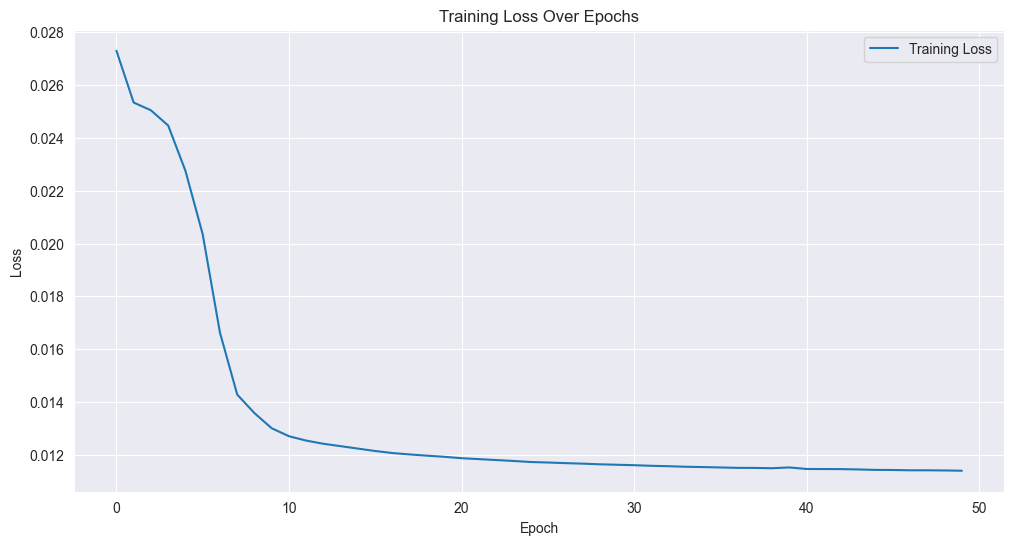

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
66min LSTM with Attention - MAE: 7.399189101259638, MSE: 90.70505102506645, RMSE: 9.523919940080683 R²: 0.5335359521638752


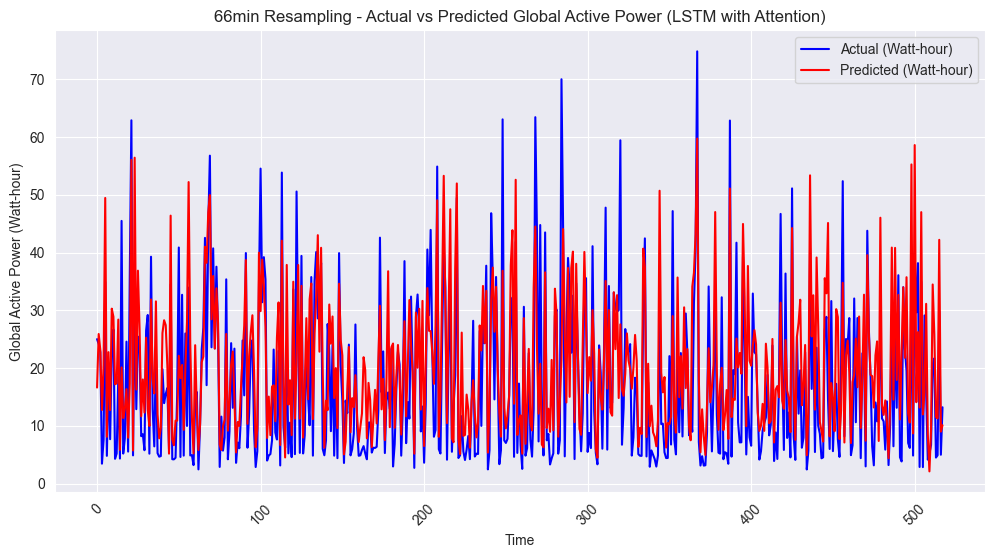

In [47]:
# Define the LSTM model with attention using the functional API
inputs_66min = Input(shape=(X_train_scaled_66min.shape[1], X_train_scaled_66min.shape[2]))
lstm_out_66min = layers.LSTM(50, return_sequences=True, activation='relu')(inputs_66min)
attention_66min = layers.Attention()([lstm_out_66min, lstm_out_66min])
attention_66min = layers.Flatten()(attention_66min)  # Flatten the attention output to 2D
dense_out_66min = layers.Dense(1)(attention_66min)

lstm_attention_model_66min = Model(inputs=inputs_66min, outputs=dense_out_66min)
lstm_attention_model_66min.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define early stopping
early_stopping_66min = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, )

# Train the LSTM model with attention
lstm_attention_history_66min = lstm_attention_model_66min.fit(X_train_scaled_66min, y_train_scaled_66min, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_66min])

# plot training loss
plot_training_history(lstm_attention_history_66min)

# Make predictions with the LSTM model with attention
y_pred_train_lstm_attention_66min = lstm_attention_model_66min.predict(X_train_scaled_66min)
y_pred_test_lstm_attention_66min = lstm_attention_model_66min.predict(X_test_scaled_66min)

# Inverse transform the predictions and actual values
y_pred_train_lstm_attention_66min_inv = scaler_y_66min.inverse_transform(y_pred_train_lstm_attention_66min).reshape(-1)
y_pred_test_lstm_attention_66min_inv = scaler_y_66min.inverse_transform(y_pred_test_lstm_attention_66min).reshape(-1)
y_train_66min_inv = scaler_y_66min.inverse_transform(y_train_scaled_66min).reshape(-1)
y_test_66min_inv = scaler_y_66min.inverse_transform(y_test_scaled_66min).reshape(-1)

# Evaluate LSTM with attention model performance
mae_lstm_attention_66min = mean_absolute_error(y_test_66min_inv, y_pred_test_lstm_attention_66min_inv)
mse_lstm_attention_66min = mean_squared_error(y_test_66min_inv, y_pred_test_lstm_attention_66min_inv)
rmse_lstm_attention_66min = math.sqrt(mse_lstm_attention_66min)
r2_lstm_attention_66min = r2_score(y_test_66min_inv, y_pred_test_lstm_attention_66min_inv)
print(f"66min LSTM with Attention - MAE: {mae_lstm_attention_66min}, MSE: {mse_lstm_attention_66min}, RMSE: {rmse_lstm_attention_66min} R²: {r2_lstm_attention_66min}")

# Plot LSTM with attention predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_66min_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_attention_66min_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('66min Resampling - Actual vs Predicted Global Active Power (LSTM with Attention)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### LSTM with Attention and a 10% data down-sampling, Conclusions:
The LSTM model with Attention and a 10% data down sampling demonstrate a RMSE score of 9.5, while the RMSE score before the down-sampling is 10.8.  
Again, it shows that the 10% data down sampling acts as a smother of the data and improved the model accuracy.

# 10. Data resolution experiment

## 10.1 Resample 1 hour to 2 hour and run RNN model

Epoch 1/50


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 - 2s - 25ms/step - loss: 0.2354
Epoch 2/50
72/72 - 0s - 3ms/step - loss: 0.1248
Epoch 3/50
72/72 - 0s - 3ms/step - loss: 0.0746
Epoch 4/50
72/72 - 0s - 2ms/step - loss: 0.0547
Epoch 5/50
72/72 - 0s - 2ms/step - loss: 0.0448
Epoch 6/50
72/72 - 0s - 2ms/step - loss: 0.0370
Epoch 7/50
72/72 - 0s - 2ms/step - loss: 0.0328
Epoch 8/50
72/72 - 0s - 2ms/step - loss: 0.0276
Epoch 9/50
72/72 - 0s - 2ms/step - loss: 0.0239
Epoch 10/50
72/72 - 0s - 2ms/step - loss: 0.0215
Epoch 11/50
72/72 - 0s - 3ms/step - loss: 0.0195
Epoch 12/50
72/72 - 0s - 2ms/step - loss: 0.0181
Epoch 13/50
72/72 - 0s - 2ms/step - loss: 0.0162
Epoch 14/50
72/72 - 0s - 2ms/step - loss: 0.0161
Epoch 15/50
72/72 - 0s - 2ms/step - loss: 0.0138
Epoch 16/50
72/72 - 0s - 2ms/step - loss: 0.0136
Epoch 17/50
72/72 - 0s - 3ms/step - loss: 0.0138
Epoch 18/50
72/72 - 0s - 2ms/step - loss: 0.0135
Epoch 19/50
72/72 - 0s - 2ms/step - loss: 0.0128
Epoch 20/50
72/72 - 0s - 2ms/step - loss: 0.0124
Epoch 21/50
72/72 - 0s - 2ms/step - los

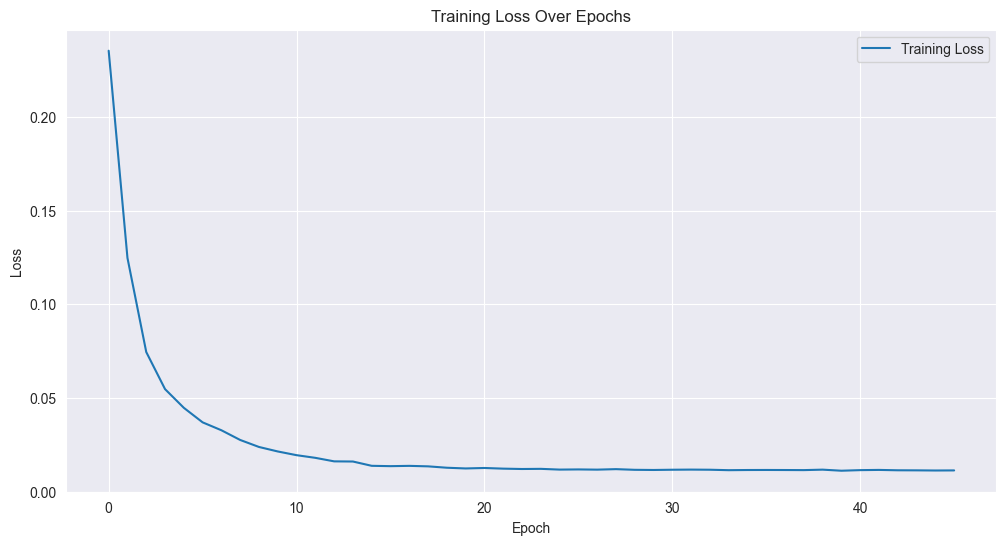

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2h RNN - MAE: 5.712478648380751, MSE: 68.08909719015989, RMSE: 8.251611793471618, R²: 0.5661108266847529


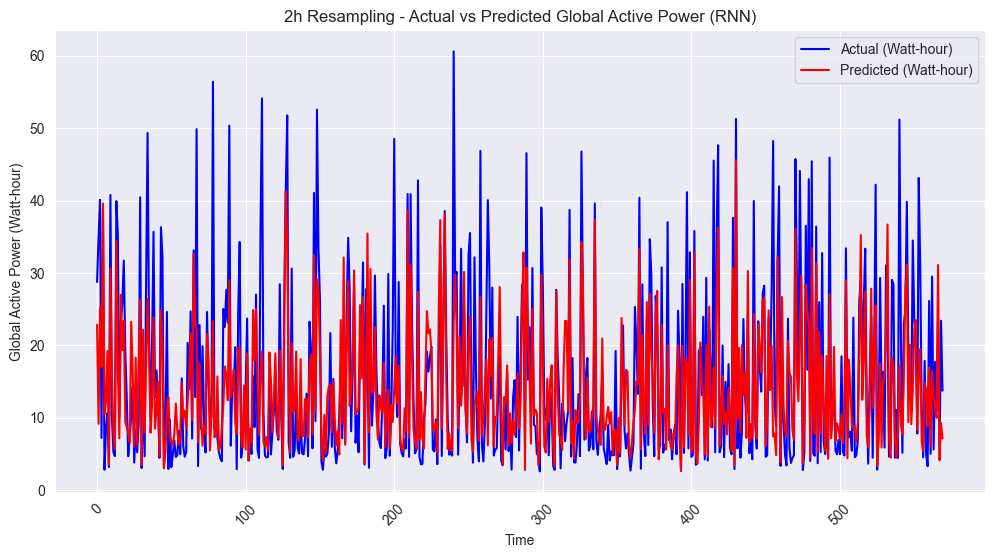

In [48]:
# Resample to 2 hours intervals
resampled_df_2h = full_df.resample('2h').mean()
resampled_df_2h = resampled_df_2h.dropna()

features_2h = ['Global_active_power_wh', 'active_energy_without_subs', 'lag_1']
target_2h = ['Global_active_power_wh']

def create_sequences_2h(data, sequence_length):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features_2h].iloc[i:i + sequence_length].values
        label = data[target_2h].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length_2h = 6
sequences_2h, targets_2h = create_sequences_2h(resampled_df_2h, sequence_length_2h)

# Train-test split
X_train_2h, X_test_2h, y_train_2h, y_test_2h = train_test_split(sequences_2h, targets_2h, test_size=0.2, random_state=42)

# Scale the features and target separately
scaler_X_2h = MinMaxScaler()
scaler_y_2h = MinMaxScaler()

X_train_scaled_2h = scaler_X_2h.fit_transform(X_train_2h.reshape(-1, X_train_2h.shape[-1])).reshape(X_train_2h.shape)
X_test_scaled_2h = scaler_X_2h.transform(X_test_2h.reshape(-1, X_test_2h.shape[-1])).reshape(X_test_2h.shape)

y_train_scaled_2h = scaler_y_2h.fit_transform(y_train_2h.reshape(-1, 1))
y_test_scaled_2h = scaler_y_2h.transform(y_test_2h.reshape(-1, 1))

# Design the RNN model
rnn_model_2h = Sequential()
rnn_model_2h.add(layers.SimpleRNN(50, activation='relu', input_shape=(X_train_scaled_2h.shape[1], X_train_scaled_2h.shape[2])))
rnn_model_2h.add(layers.BatchNormalization())
rnn_model_2h.add(layers.Dropout(0.2))
rnn_model_2h.add(layers.Dense(1))
rnn_model_2h.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping_2h = callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)

# Train the RNN model
rnn_history_2h = rnn_model_2h.fit(X_train_scaled_2h, y_train_scaled_2h, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_2h])

plot_training_history(rnn_history_2h)

# Make predictions with the RNN model
y_pred_train_rnn_2h = rnn_model_2h.predict(X_train_scaled_2h)
y_pred_test_rnn_2h = rnn_model_2h.predict(X_test_scaled_2h)

# Inverse transform the predictions and actual values
y_pred_train_rnn_2h_inv = scaler_y_2h.inverse_transform(y_pred_train_rnn_2h).reshape(-1)
y_pred_test_rnn_2h_inv = scaler_y_2h.inverse_transform(y_pred_test_rnn_2h).reshape(-1)
y_train_2h_inv = scaler_y_2h.inverse_transform(y_train_scaled_2h).reshape(-1)
y_test_2h_inv = scaler_y_2h.inverse_transform(y_test_scaled_2h).reshape(-1)

# Evaluate RNN model performance
mae_rnn_2h = mean_absolute_error(y_test_2h_inv, y_pred_test_rnn_2h_inv)
mse_rnn_2h = mean_squared_error(y_test_2h_inv, y_pred_test_rnn_2h_inv)
rmse_rnn_2h = math.sqrt(mse_rnn_2h)
r2_rnn_2h = r2_score(y_test_2h_inv, y_pred_test_rnn_2h_inv)

print(f"2h RNN - MAE: {mae_rnn_2h}, MSE: {mse_rnn_2h}, RMSE: {rmse_rnn_2h}, R²: {r2_rnn_2h}")

# Plot RNN predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_2h_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_rnn_2h_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('2h Resampling - Actual vs Predicted Global Active Power (RNN)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### RNN with 50% data down-sampling Conclusions:
The RNN model with 50% data down sampling demonstrate a RMSE score of 8.3 while, while the RMSE score with 10% down-sampling was  10.1 and before the down-sampling was 10.7.   
We continue to see that down sampling acts as a smother of the data and improves the model accuracy.

## 10.2 Data resoultion 2 hours using LSTM

Epoch 1/50


C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 - 2s - 35ms/step - loss: 0.0324
Epoch 2/50
72/72 - 0s - 4ms/step - loss: 0.0192
Epoch 3/50
72/72 - 0s - 4ms/step - loss: 0.0177
Epoch 4/50
72/72 - 0s - 4ms/step - loss: 0.0155
Epoch 5/50
72/72 - 0s - 3ms/step - loss: 0.0143
Epoch 6/50
72/72 - 0s - 3ms/step - loss: 0.0135
Epoch 7/50
72/72 - 0s - 3ms/step - loss: 0.0128
Epoch 8/50
72/72 - 0s - 3ms/step - loss: 0.0130
Epoch 9/50
72/72 - 0s - 3ms/step - loss: 0.0127
Epoch 10/50
72/72 - 0s - 3ms/step - loss: 0.0127
Epoch 11/50
72/72 - 0s - 3ms/step - loss: 0.0122
Epoch 12/50
72/72 - 0s - 3ms/step - loss: 0.0124
Epoch 13/50
72/72 - 0s - 3ms/step - loss: 0.0124
Epoch 14/50
72/72 - 0s - 3ms/step - loss: 0.0120
Epoch 15/50
72/72 - 0s - 3ms/step - loss: 0.0123
Epoch 16/50
72/72 - 0s - 3ms/step - loss: 0.0122
Epoch 17/50
72/72 - 0s - 3ms/step - loss: 0.0122
Epoch 18/50
72/72 - 0s - 3ms/step - loss: 0.0121
Epoch 19/50
72/72 - 0s - 3ms/step - loss: 0.0120
Epoch 20/50
72/72 - 0s - 3ms/step - loss: 0.0121
Epoch 21/50
72/72 - 0s - 4ms/step - los

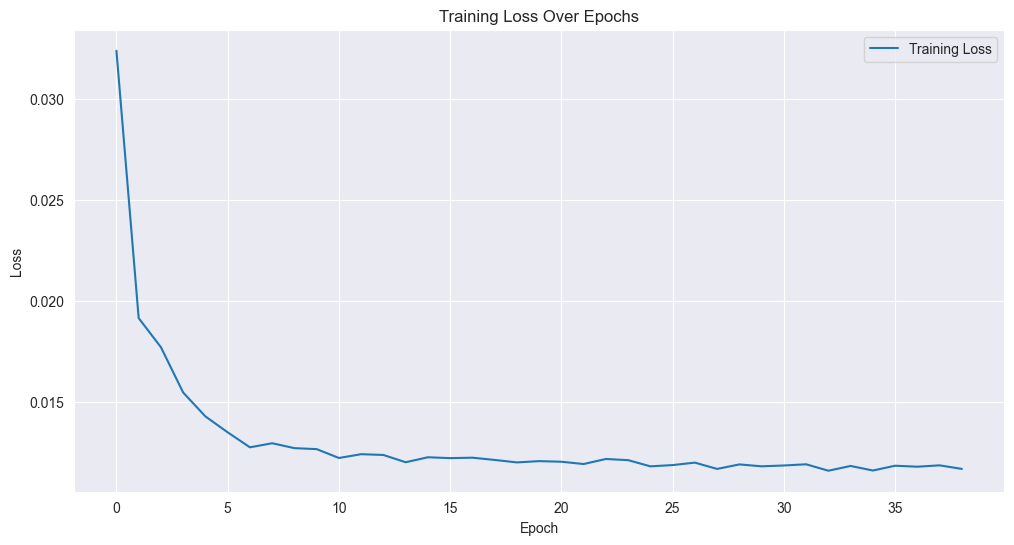

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2h LSTM - MAE: 6.388790850674488, MSE: 70.33218139508315, RMSE: 8.38642840517244, R²: 0.5518170558533884


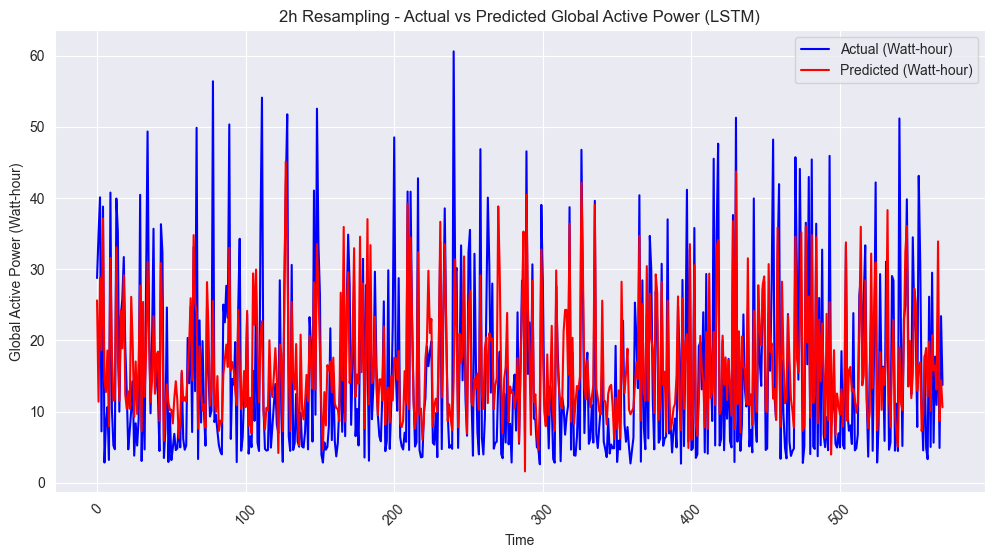

In [49]:
# Design the LSTM model
lstm_model_2h = Sequential()
lstm_model_2h.add(layers.LSTM(50, activation='relu', input_shape=(X_train_scaled_2h.shape[1], X_train_scaled_2h.shape[2])))
lstm_model_2h.add(layers.BatchNormalization())
lstm_model_2h.add(layers.Dropout(0.2))
lstm_model_2h.add(layers.Dense(1))
lstm_model_2h.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping_2h = callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)

# Train the LSTM model
lstm_history_2h = lstm_model_2h.fit(X_train_scaled_2h, y_train_scaled_2h, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_2h])

# plot training loss
plot_training_history(lstm_history_2h)

# Make predictions with the LSTM model
y_pred_train_lstm_2h = lstm_model_2h.predict(X_train_scaled_2h)
y_pred_test_lstm_2h = lstm_model_2h.predict(X_test_scaled_2h)

# Inverse transform the predictions and actual values
y_pred_train_lstm_2h_inv = scaler_y_2h.inverse_transform(y_pred_train_lstm_2h).reshape(-1)
y_pred_test_lstm_2h_inv = scaler_y_2h.inverse_transform(y_pred_test_lstm_2h).reshape(-1)
y_train_2h_inv = scaler_y_2h.inverse_transform(y_train_scaled_2h).reshape(-1)
y_test_2h_inv = scaler_y_2h.inverse_transform(y_test_scaled_2h).reshape(-1)

# Evaluate LSTM model performance
mae_lstm_2h = mean_absolute_error(y_test_2h_inv, y_pred_test_lstm_2h_inv)
mse_lstm_2h = mean_squared_error(y_test_2h_inv, y_pred_test_lstm_2h_inv)
rmse_lstm_2h = math.sqrt(mse_lstm_2h)
r2_lstm_2h = r2_score(y_test_2h_inv, y_pred_test_lstm_2h_inv)

print(f"2h LSTM - MAE: {mae_lstm_2h}, MSE: {mse_lstm_2h}, RMSE: {rmse_lstm_2h}, R²: {r2_lstm_2h}")

# Plot LSTM predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_2h_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_2h_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('2h Resampling - Actual vs Predicted Global Active Power (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### LSTM with 50% data down-sampling Conclusions:
The LSTM model with 50% data down sampling demonstrate a RMSE score of 8.3 while, while the RMSE score with 10% down-sampling was  9.3 and before the down-sampling was 10.6.   
We continue to see that down sampling acts as a smother of the data and improves the model accuracy.

## 10.3 Data resolution 2 hours LSTM with Attention

Epoch 1/50
72/72 - 2s - 27ms/step - accuracy: 4.3898e-04 - loss: 0.0257
Epoch 2/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0223
Epoch 3/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0212
Epoch 4/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0192
Epoch 5/50
72/72 - 0s - 4ms/step - accuracy: 4.3898e-04 - loss: 0.0164
Epoch 6/50
72/72 - 0s - 4ms/step - accuracy: 4.3898e-04 - loss: 0.0143
Epoch 7/50
72/72 - 0s - 4ms/step - accuracy: 4.3898e-04 - loss: 0.0122
Epoch 8/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0118
Epoch 9/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0115
Epoch 10/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0114
Epoch 11/50
72/72 - 0s - 4ms/step - accuracy: 4.3898e-04 - loss: 0.0113
Epoch 12/50
72/72 - 0s - 4ms/step - accuracy: 4.3898e-04 - loss: 0.0112
Epoch 13/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0112
Epoch 14/50
72/72 - 0s - 3ms/step - accuracy: 4.3898e-04 - loss: 0.0111


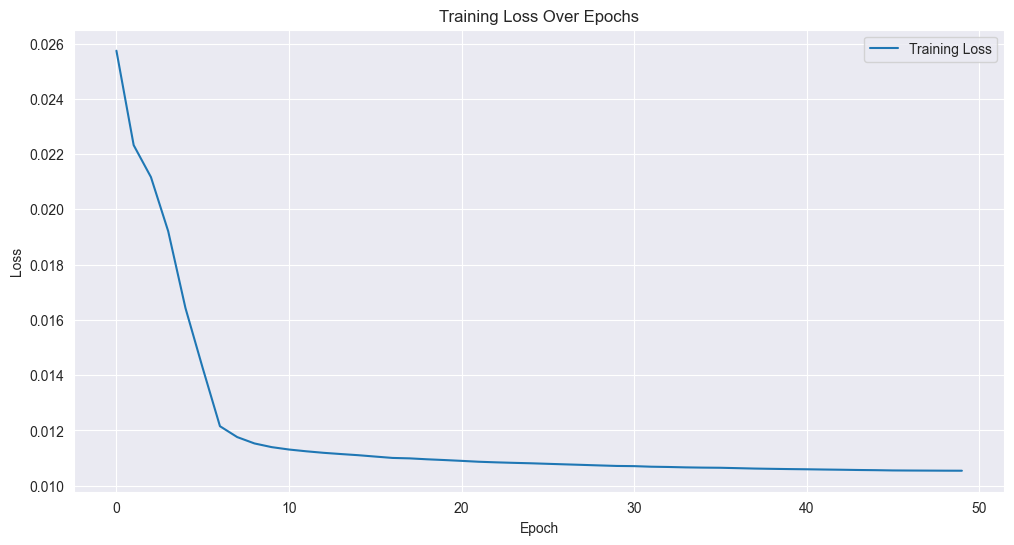

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2h LSTM with Attention - MAE: 5.68446713365198, MSE: 67.57166846158198, RMSE: 8.220198809127549, R²: 0.5694080759149083


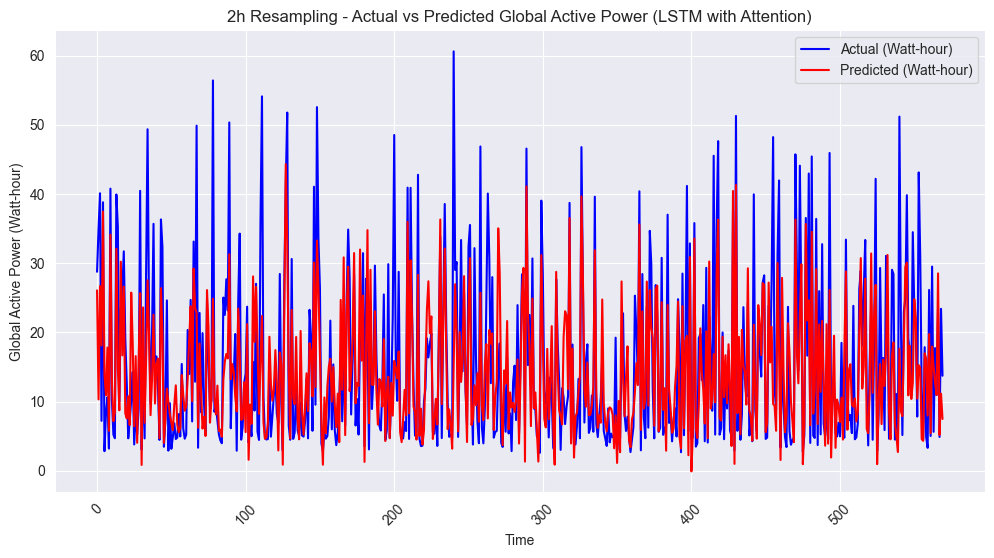

In [50]:
# Define the LSTM model with attention using the functional API
inputs_2h = Input(shape=(X_train_scaled_2h.shape[1], X_train_scaled_2h.shape[2]))
lstm_out_2h = layers.LSTM(50, return_sequences=True, activation='relu')(inputs_2h)
attention_2h = layers.Attention()([lstm_out_2h, lstm_out_2h])
attention_2h = layers.Flatten()(attention_2h)  # Flatten the attention output to 2D
dense_out_2h = layers.Dense(1)(attention_2h)

lstm_attention_model_2h = Model(inputs=inputs_2h, outputs=dense_out_2h)
lstm_attention_model_2h.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define early stopping
early_stopping_2h = callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)

# Train the LSTM model with attention
lstm_attention_history_2h = lstm_attention_model_2h.fit(X_train_scaled_2h, y_train_scaled_2h, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping_2h])

# plot training loss
plot_training_history(lstm_attention_history_2h)

# Make predictions with the LSTM model with attention
y_pred_train_lstm_attention_2h = lstm_attention_model_2h.predict(X_train_scaled_2h)
y_pred_test_lstm_attention_2h = lstm_attention_model_2h.predict(X_test_scaled_2h)

# Inverse transform the predictions and actual values
y_pred_train_lstm_attention_2h_inv = scaler_y_2h.inverse_transform(y_pred_train_lstm_attention_2h).reshape(-1)
y_pred_test_lstm_attention_2h_inv = scaler_y_2h.inverse_transform(y_pred_test_lstm_attention_2h).reshape(-1)
y_train_2h_inv = scaler_y_2h.inverse_transform(y_train_scaled_2h).reshape(-1)
y_test_2h_inv = scaler_y_2h.inverse_transform(y_test_scaled_2h).reshape(-1)

# Evaluate LSTM with attention model performance
mae_lstm_attention_2h = mean_absolute_error(y_test_2h_inv, y_pred_test_lstm_attention_2h_inv)
mse_lstm_attention_2h = mean_squared_error(y_test_2h_inv, y_pred_test_lstm_attention_2h_inv)
rmse_lstm_attention_2h = math.sqrt(mse_lstm_attention_2h)
r2_lstm_attention_2h = r2_score(y_test_2h_inv, y_pred_test_lstm_attention_2h_inv)
print(f"2h LSTM with Attention - MAE: {mae_lstm_attention_2h}, MSE: {mse_lstm_attention_2h}, RMSE: {rmse_lstm_attention_2h}, R²: {r2_lstm_attention_2h}")

# Plot LSTM with attention predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_2h_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_lstm_attention_2h_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('2h Resampling - Actual vs Predicted Global Active Power (LSTM with Attention)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### LSTM with attention and a 50% data down-sampling Conclusions:
The LSTM model with attention and a 50% data down sampling demonstrate a RMSE score of 8.2 while, while the RMSE score with 10% down-sampling was  9.5 and before the down-sampling was 10.8.   
We continue to see that down sampling acts as a smother of the data and improves the model accuracy.

# 11. Conclusion and insights

We didn't see a large difference between the results of the RNN, LSTM and LSTM with attention.  
We did see an improvement in preforments of all models when working with down sampled data.  
The conclusion it that working with a data set with a very high sampling rate can be computational expensive and will not necessarily give the best results. one needs to find the optimal data resumption that will give the best results.